### Name: Ntwali Bruno Bahongere
#### Course: Advanced Big Data and Data Mining
#### Residency Project_Shoppers Behavior Analysis

In [4]:
import kagglehub
import pandas as pd
import os
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, validation_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA

from mlxtend.frequent_patterns import fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder


import time

import warnings
warnings.filterwarnings('ignore')

In [5]:
# Download latest version
path = kagglehub.dataset_download("subhajournal/shoppers-behavior-and-revenue")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\nBruno\.cache\kagglehub\datasets\subhajournal\shoppers-behavior-and-revenue\versions\1


In [6]:
# importing data to pandas dataframe
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
df = pd.read_csv(os.path.join(path, csv_files[0]))
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [7]:
# Data Exploration and Initial Analysis
print("Dataset Shape:", df.shape)
print("\nColumn Names and Data Types:")
print(df.dtypes)
print("\nDataset Info:")
df.info()
print("\nBasic Statistics:")
print(df.describe())

Dataset Shape: (12330, 18)

Column Names and Data Types:
Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administ

In [8]:
# Checcking for missing values
missing_values = df.isnull().sum()
print(missing_values)

print("\nMissing values percentage:")
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing_Count': missing_values.values,
    'Missing_Percentage': missing_percentage.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)
print(missing_df)

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

Missing values percentage:
Empty DataFrame
Columns: [Column, Missing_Count, Missing_Percentage]
Index: []


In [9]:
# Check for duplicate records
print(f"Total records: {len(df)}")
print(f"Duplicate records: {df.duplicated().sum()}")
print(f"Unique records: {len(df) - df.duplicated().sum()}")

if df.duplicated().sum() > 0:
    print("\nDuplicate records preview:")
    print(df[df.duplicated()].head())

# Check for negative values in numeric columns that shouldn't be negative
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
print("\nChecking for negative values in numeric columns:")
for col in numeric_cols:
    negative_count = (df[col] < 0).sum()
    if negative_count > 0:
        print(f"{col}: {negative_count} negative values")

# Check for outliers using IQR method
print("\nChecking for potential outliers (values beyond 3*IQR):")
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    if len(outliers) > 0:
        print(f"{col}: {len(outliers)} potential outliers ({len(outliers)/len(df)*100:.2f}%)")

# Check categorical variables
print("\nCategorical variables unique values:")
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values - {df[col].unique()}")

Total records: 12330


Duplicate records: 125
Unique records: 12205

Duplicate records preview:
     Administrative  Administrative_Duration  Informational  \
158               0                      0.0              0   
159               0                      0.0              0   
178               0                      0.0              0   
418               0                      0.0              0   
456               0                      0.0              0   

     Informational_Duration  ProductRelated  ProductRelated_Duration  \
158                     0.0               1                      0.0   
159                     0.0               1                      0.0   
178                     0.0               1                      0.0   
418                     0.0               1                      0.0   
456                     0.0               1                      0.0   

     BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
158          0.2        0.2         

In [10]:
if 'df_cleaned' not in locals():
	df_cleaned = df.copy().drop_duplicates()

print("\nData types after cleaning:")
print(df_cleaned.dtypes)

print("\nFirst 5 rows of cleaned data:")
print(df_cleaned.head())


Data types after cleaning:
Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

First 5 rows of cleaned data:
   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0           

Numerical features: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']


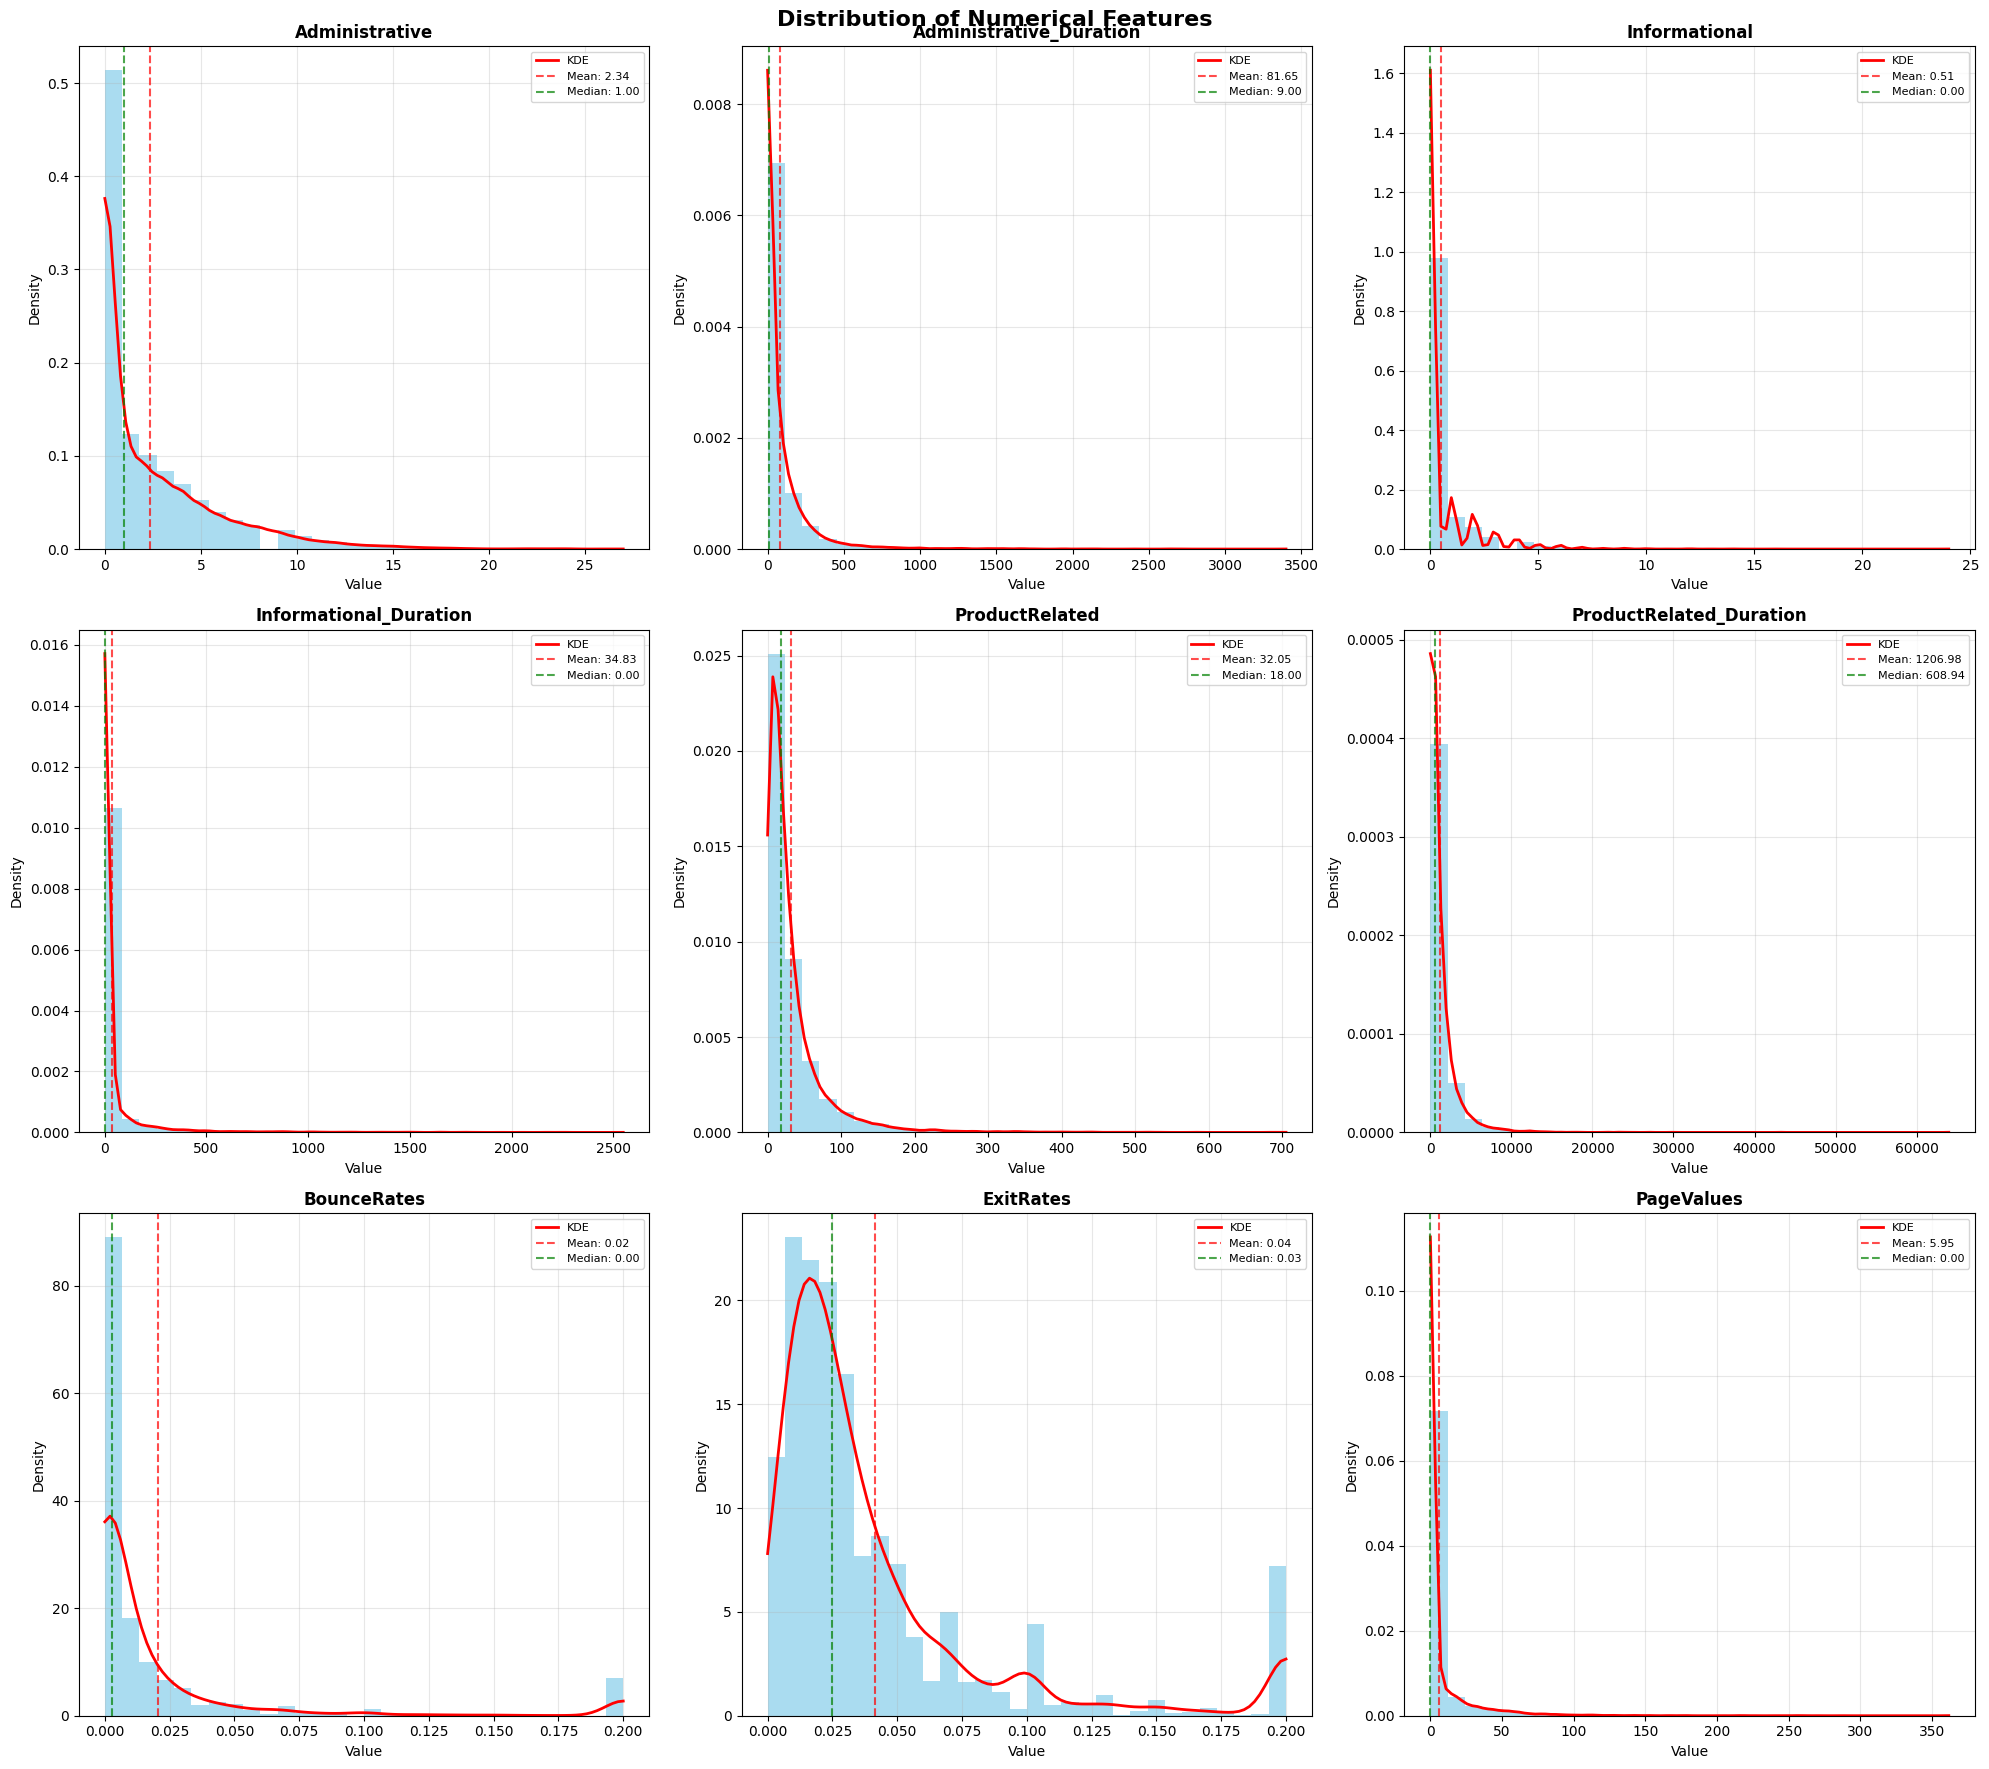


Detailed Statistical Summary:
--------------------------------------------------------------------------------

Administrative:
  Mean: 2.34 | Median: 1.00
  Std: 3.33 | Min: 0.00 | Max: 27.00
  Skewness: 1.95 | Kurtosis: 4.64
  Distribution: Highly skewed

Administrative_Duration:
  Mean: 81.65 | Median: 9.00
  Std: 177.49 | Min: 0.00 | Max: 3398.75
  Skewness: 5.59 | Kurtosis: 50.14
  Distribution: Highly skewed

Informational:
  Mean: 0.51 | Median: 0.00
  Std: 1.28 | Min: 0.00 | Max: 24.00
  Skewness: 4.01 | Kurtosis: 26.66
  Distribution: Highly skewed

Informational_Duration:
  Mean: 34.83 | Median: 0.00
  Std: 141.42 | Min: 0.00 | Max: 2549.38
  Skewness: 7.54 | Kurtosis: 75.53
  Distribution: Highly skewed

ProductRelated:
  Mean: 32.05 | Median: 18.00
  Std: 44.59 | Min: 0.00 | Max: 705.00
  Skewness: 4.33 | Kurtosis: 31.07
  Distribution: Highly skewed

ProductRelated_Duration:
  Mean: 1206.98 | Median: 608.94
  Std: 1919.60 | Min: 0.00 | Max: 63973.52
  Skewness: 7.25 | Kur

In [11]:
# Numeriacl features distribution analysis

# Identify numerical columns
numerical_cols = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numerical features: {numerical_cols}")

# Create distribution plots
fig, axes = plt.subplots(3, 3, figsize=(20, 18))
fig.suptitle('Distribution of Numerical Features', fontsize=16, fontweight='bold')

for i, col in enumerate(numerical_cols):
    if i < 9:  # Plot first 9 numerical columns
        row = i // 3
        col_idx = i % 3
        
        # Create histogram with KDE
        axes[row, col_idx].hist(df_cleaned[col], bins=30, alpha=0.7, color='skyblue', density=True)
        
        # Add KDE line
        try:
            kde_x = np.linspace(df_cleaned[col].min(), df_cleaned[col].max(), 100)
            kde = stats.gaussian_kde(df_cleaned[col].dropna())
            axes[row, col_idx].plot(kde_x, kde(kde_x), 'r-', linewidth=2, label='KDE')
        except:
            pass
            
        axes[row, col_idx].set_title(f'{col}', fontweight='bold')
        axes[row, col_idx].set_xlabel('Value')
        axes[row, col_idx].set_ylabel('Density')
        axes[row, col_idx].grid(True, alpha=0.3)
        
        # Add basic statistics as text
        mean_val = df_cleaned[col].mean()
        median_val = df_cleaned[col].median()
        axes[row, col_idx].axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_val:.2f}')
        axes[row, col_idx].axvline(median_val, color='green', linestyle='--', alpha=0.7, label=f'Median: {median_val:.2f}')
        axes[row, col_idx].legend(fontsize=8)

plt.tight_layout()
plt.show()

# Statistical summary of numerical features
print("\nDetailed Statistical Summary:")
print("-" * 80)
for col in numerical_cols[:6]:  # Focus on key columns
    print(f"\n{col}:")
    print(f"  Mean: {df_cleaned[col].mean():.2f} | Median: {df_cleaned[col].median():.2f}")
    print(f"  Std: {df_cleaned[col].std():.2f} | Min: {df_cleaned[col].min():.2f} | Max: {df_cleaned[col].max():.2f}")
    print(f"  Skewness: {df_cleaned[col].skew():.2f} | Kurtosis: {df_cleaned[col].kurtosis():.2f}")
    
    # Interpret skewness
    skew = df_cleaned[col].skew()
    if abs(skew) < 0.5:
        skew_interpretation = "Approximately symmetric"
    elif abs(skew) < 1:
        skew_interpretation = "Moderately skewed"
    else:
        skew_interpretation = "Highly skewed"
    print(f"  Distribution: {skew_interpretation}")

# Check for zero-inflated distributions
print("\n" + "="*40)
print("ZERO-INFLATED ANALYSIS")
print("="*40)
zero_inflation_summary = []
for col in numerical_cols:
    zero_count = (df_cleaned[col] == 0).sum()
    zero_pct = (zero_count / len(df_cleaned)) * 100
    if zero_pct > 10:  # Flag columns with >10% zeros
        zero_inflation_summary.append({
            'Column': col,
            'Zero_Count': zero_count,
            'Zero_Percentage': zero_pct
        })

if zero_inflation_summary:
    zero_df = pd.DataFrame(zero_inflation_summary)
    print("Columns with significant zero values (>10%):")
    print(zero_df.to_string(index=False))
    print("\nInsight: Zero-inflated features might need special treatment in modeling.")
else:
    print("No significant zero-inflation detected in numerical features.")

Categorical features: ['Month', 'VisitorType', 'Weekend', 'Revenue']


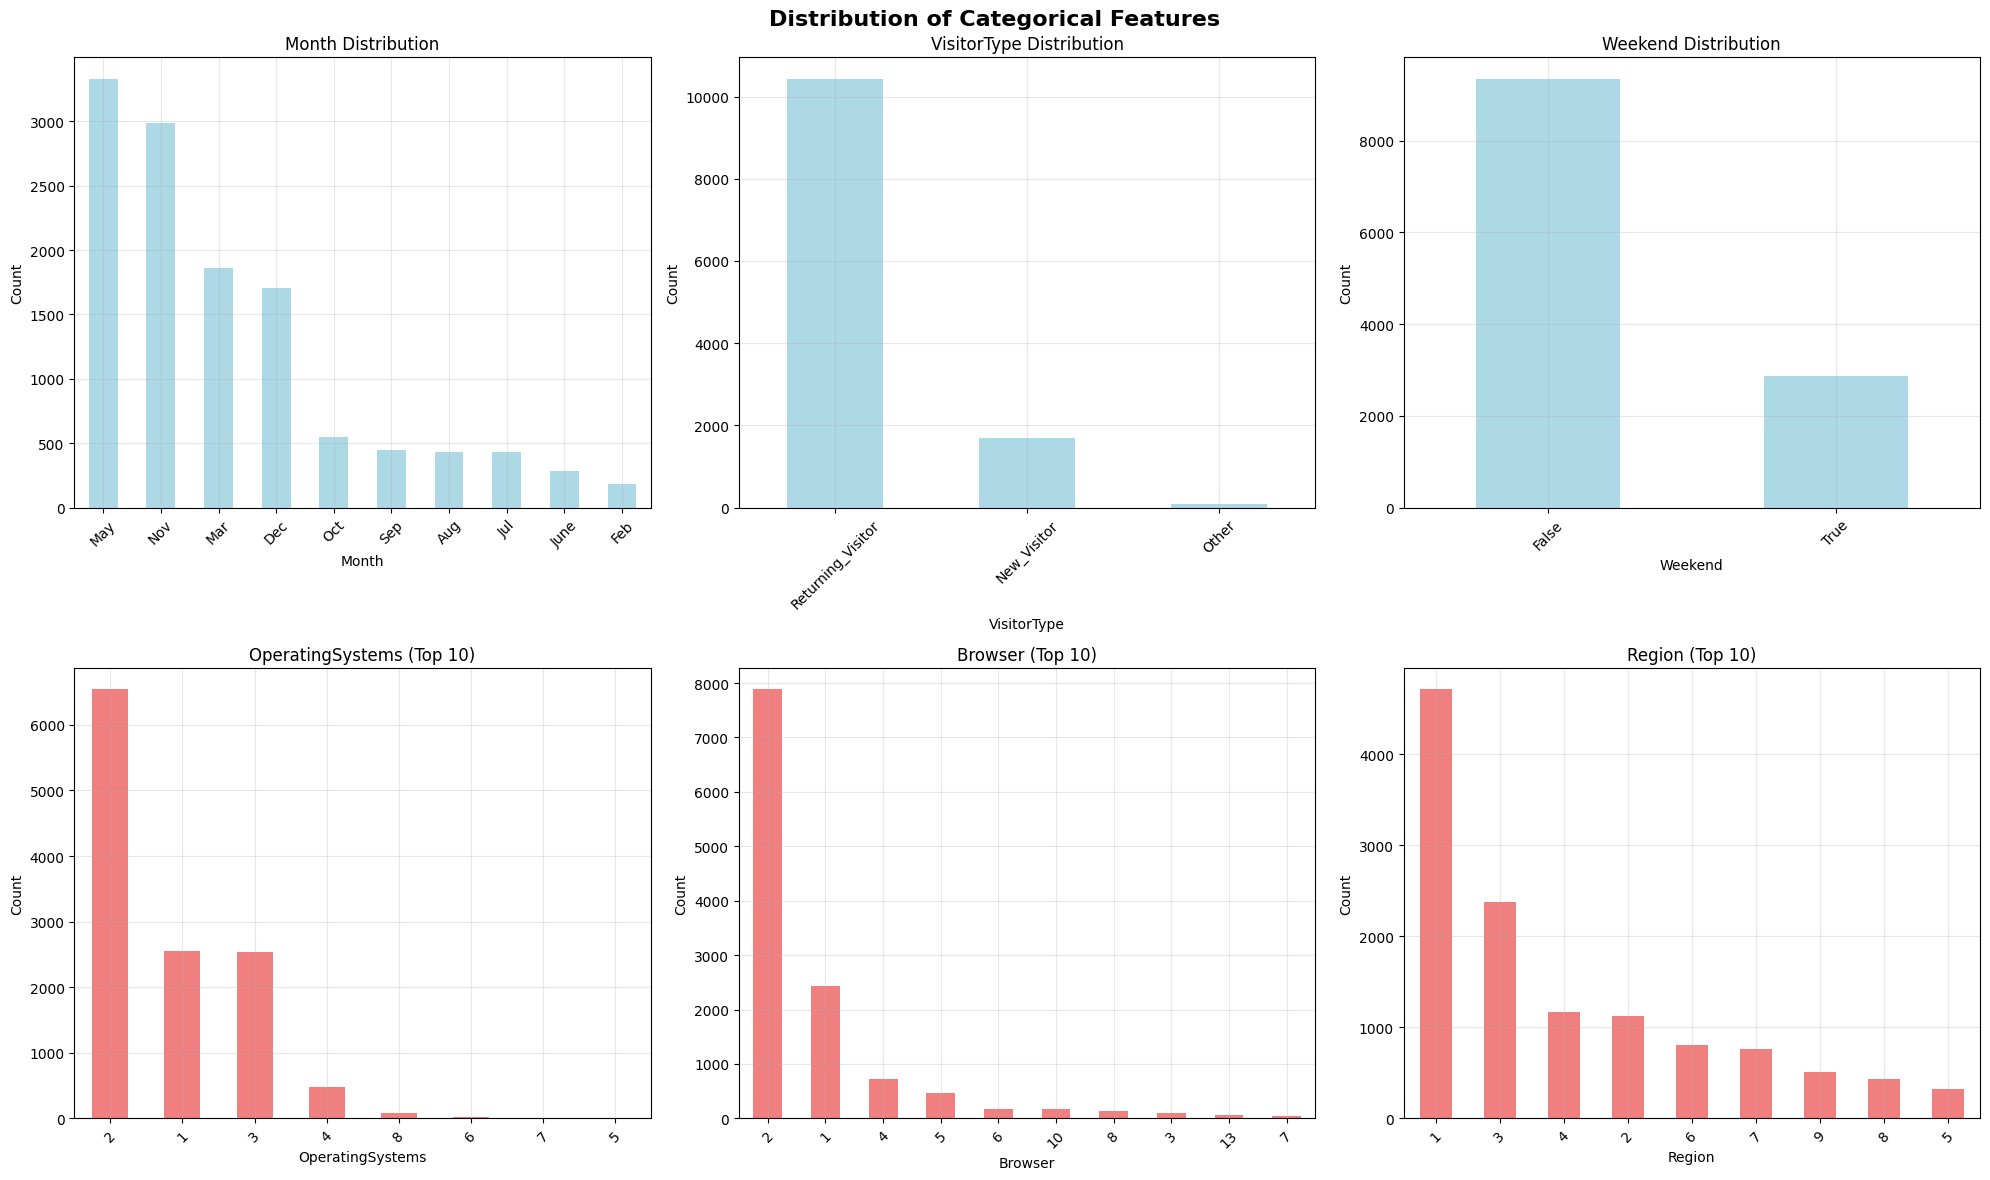


Categorical Features Summary:
------------------------------------------------------------

Month:
  Unique values: 10
    May: 3,329 (27.3%)
    Nov: 2,982 (24.4%)
    Mar: 1,860 (15.2%)
    Dec: 1,706 (14.0%)
    Oct: 549 (4.5%)
    Sep: 448 (3.7%)
    Aug: 433 (3.5%)
    Jul: 432 (3.5%)
    June: 285 (2.3%)
    Feb: 181 (1.5%)

VisitorType:
  Unique values: 3
    Returning_Visitor: 10,431 (85.5%)
    New_Visitor: 1,693 (13.9%)
    Other: 81 (0.7%)

Weekend:
  Unique values: 2
    False: 9,346 (76.6%)
    True: 2,859 (23.4%)

Revenue:
  Unique values: 2
    False: 10,297 (84.4%)
    True: 1,908 (15.6%)


In [12]:
# Categorical features analysis

# Identify categorical columns
categorical_cols = df_cleaned.select_dtypes(include=['object', 'bool']).columns.tolist()
print(f"Categorical features: {categorical_cols}")

# Create visualizations for categorical features
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Distribution of Categorical Features', fontsize=16, fontweight='bold')

categorical_plots = ['Month', 'VisitorType', 'Weekend', 'OperatingSystems', 'Browser', 'Region']

for i, col in enumerate(categorical_plots):
    if i < 6 and col in df_cleaned.columns:
        row = i // 3
        col_idx = i % 3
        
        if col in ['OperatingSystems', 'Browser', 'Region']:
            # For high-cardinality features, show top 10
            top_values = df_cleaned[col].value_counts().head(10)
            top_values.plot(kind='bar', ax=axes[row, col_idx], color='lightcoral')
            axes[row, col_idx].set_title(f'{col} (Top 10)')
        else:
            # For low-cardinality features, show all
            df_cleaned[col].value_counts().plot(kind='bar', ax=axes[row, col_idx], color='lightblue')
            axes[row, col_idx].set_title(f'{col} Distribution')
        
        axes[row, col_idx].set_xlabel(col)
        axes[row, col_idx].set_ylabel('Count')
        axes[row, col_idx].tick_params(axis='x', rotation=45)
        axes[row, col_idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed analysis of categorical features
print("\nCategorical Features Summary:")
print("-" * 60)
for col in categorical_cols:
    unique_count = df_cleaned[col].nunique()
    print(f"\n{col}:")
    print(f"  Unique values: {unique_count}")
    
    if unique_count <= 10:
        # Show all values for low cardinality
        value_counts = df_cleaned[col].value_counts()
        for value, count in value_counts.items():
            percentage = (count / len(df_cleaned)) * 100
            print(f"    {value}: {count:,} ({percentage:.1f}%)")
    else:
        # Show top 5 for high cardinality
        print("  Top 5 values:")
        value_counts = df_cleaned[col].value_counts().head(5)
        for value, count in value_counts.items():
            percentage = (count / len(df_cleaned)) * 100
            print(f"    {value}: {count:,} ({percentage:.1f}%)")
        print(f"    ... and {unique_count - 5} more values")


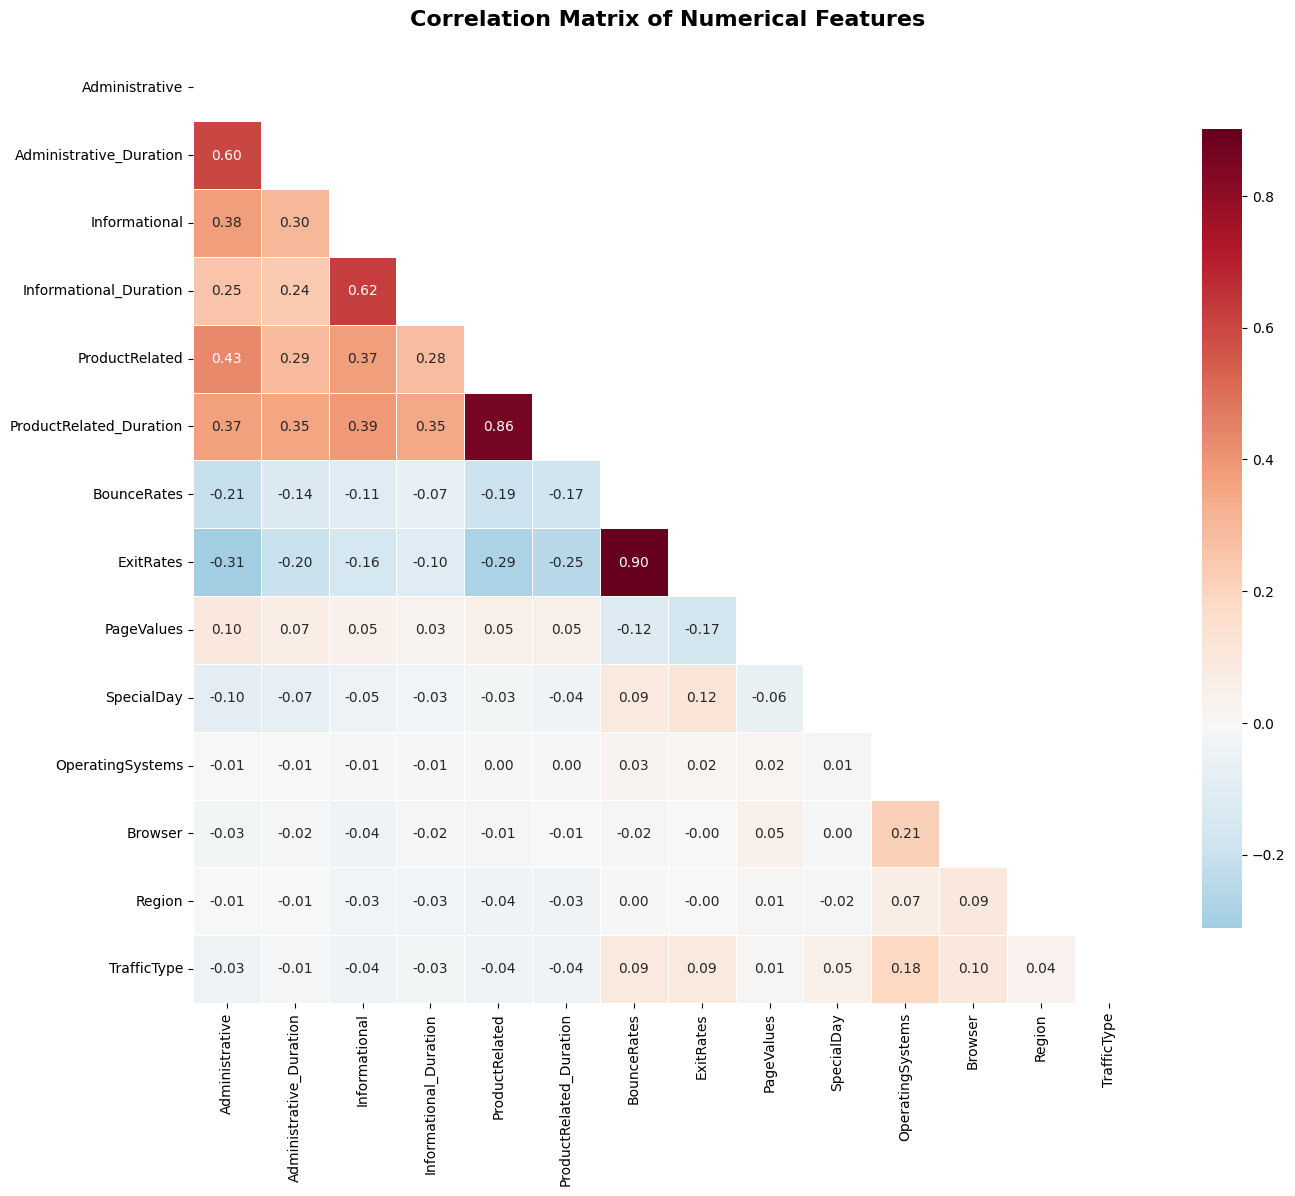

High Correlations (|correlation| > 0.7):
  ProductRelated ↔ ProductRelated_Duration: 0.860
  BounceRates ↔ ExitRates: 0.902

Correlation with Target Variable (Revenue):
--------------------------------------------------
  PageValues: 0.492 (Strong Positive)
  ExitRates: -0.204 (Moderate Negative)
  ProductRelated: 0.156 (Moderate Positive)
  ProductRelated_Duration: 0.150 (Moderate Positive)
  BounceRates: -0.145 (Moderate Negative)
  Administrative: 0.136 (Moderate Positive)
  Informational: 0.094 (Weak Positive)
  Administrative_Duration: 0.092 (Weak Positive)
  SpecialDay: -0.084 (Weak Negative)
  Informational_Duration: 0.069 (Weak Positive)
  Browser: 0.024 (Weak Positive)
  OperatingSystems: -0.015 (Weak Negative)
  Region: -0.013 (Weak Negative)
  TrafficType: -0.006 (Weak Negative)


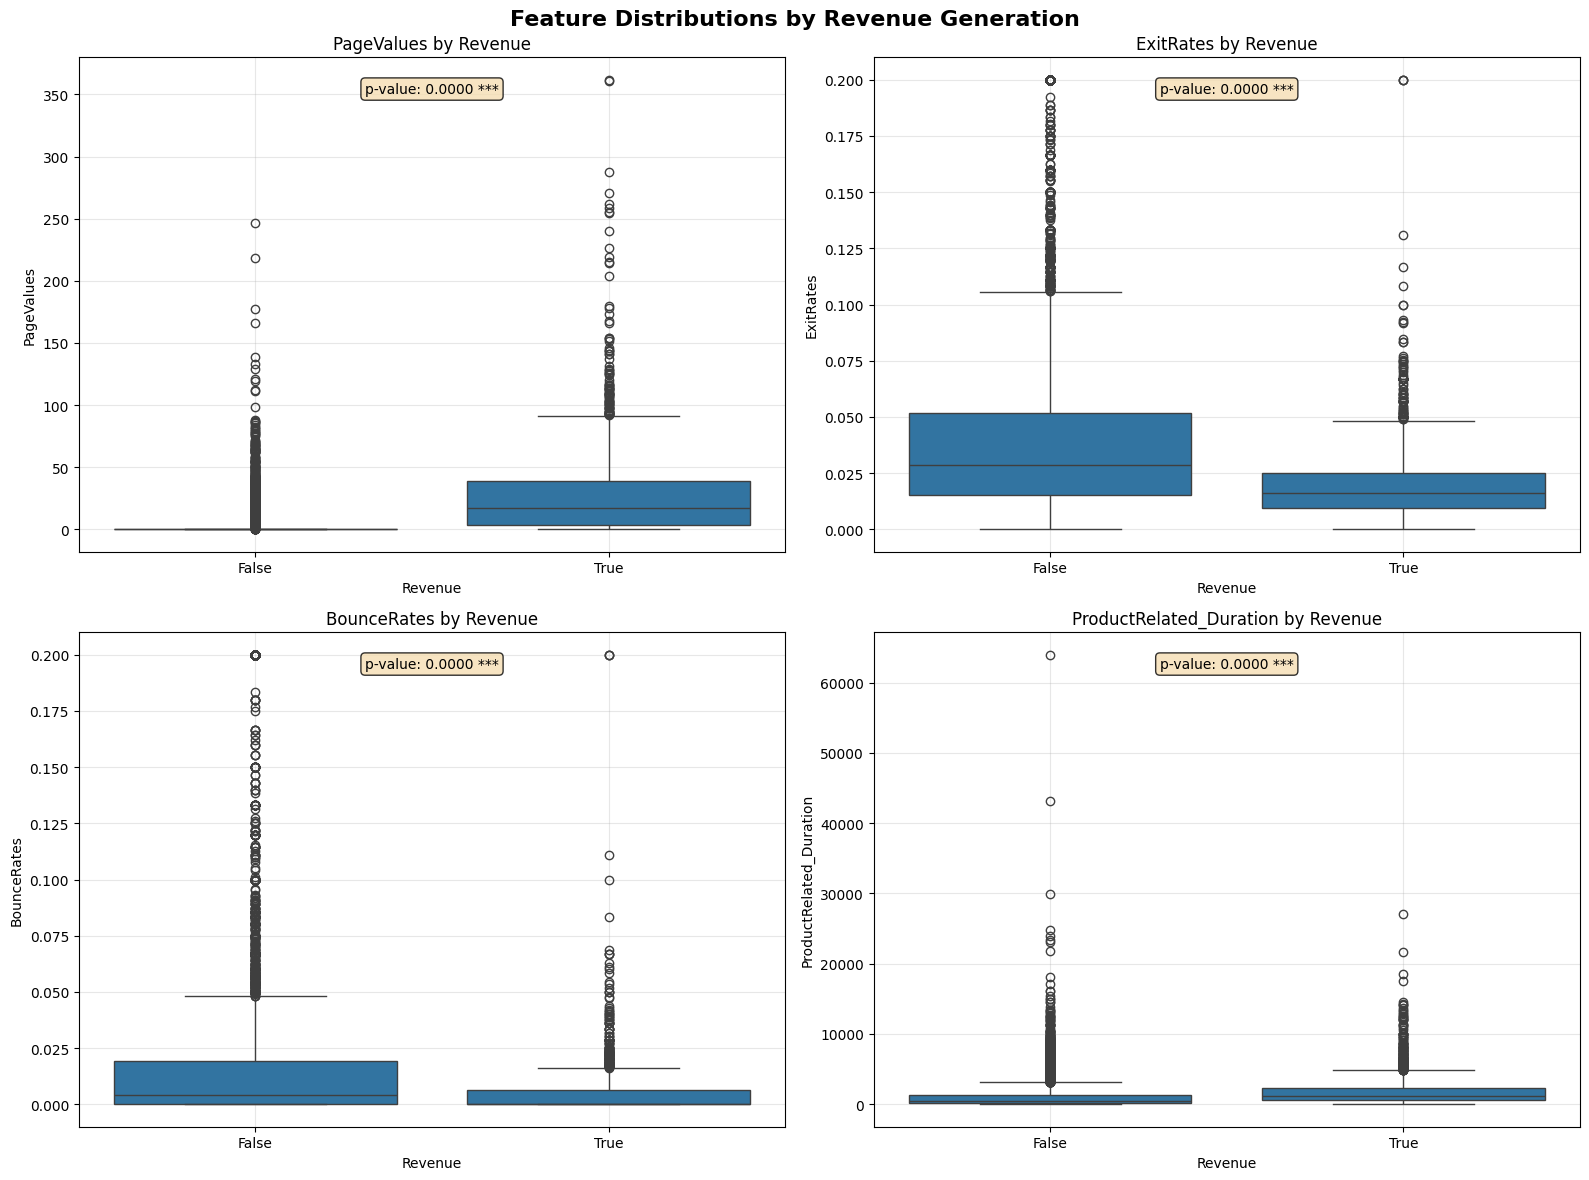


Statistical significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant


In [13]:
# Correlation analysis 

# Calculate correlation matrix for numerical features
numerical_features = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = df_cleaned[numerical_features].corr()

# Create correlation heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Show only lower triangle
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.2f')
plt.title('Correlation Matrix of Numerical Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Find high correlations (absolute value > 0.7)
high_correlations = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) > 0.7:
            high_correlations.append({
                'Feature_1': correlation_matrix.columns[i],
                'Feature_2': correlation_matrix.columns[j],
                'Correlation': correlation
            })

if high_correlations:
    print("High Correlations (|correlation| > 0.7):")
    for corr in high_correlations:
        print(f"  {corr['Feature_1']} ↔ {corr['Feature_2']}: {corr['Correlation']:.3f}")
else:
    print("No high correlations (>0.7) found between numerical features.")

# Correlation with target variable (Revenue)
# Convert Revenue to numeric for correlation
df_cleaned['Revenue_numeric'] = df_cleaned['Revenue'].astype(int)
target_correlations = df_cleaned[numerical_features + ['Revenue_numeric']].corr()['Revenue_numeric'].drop('Revenue_numeric')
target_correlations = target_correlations.sort_values(key=abs, ascending=False)

print(f"\nCorrelation with Target Variable (Revenue):")
print("-" * 50)
for feature, correlation in target_correlations.items():
    strength = "Strong" if abs(correlation) > 0.3 else "Moderate" if abs(correlation) > 0.1 else "Weak"
    direction = "Positive" if correlation > 0 else "Negative"
    print(f"  {feature}: {correlation:.3f} ({strength} {direction})")

# Feature relationships with Revenue - Box plots for key features
key_features = ['PageValues', 'ExitRates', 'BounceRates', 'ProductRelated_Duration']
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Feature Distributions by Revenue Generation', fontsize=16, fontweight='bold')

for i, feature in enumerate(key_features):
    if feature in df_cleaned.columns:
        row = i // 2
        col = i % 2
        
        sns.boxplot(data=df_cleaned, x='Revenue', y=feature, ax=axes[row, col])
        axes[row, col].set_title(f'{feature} by Revenue')
        axes[row, col].grid(True, alpha=0.3)
        
        # Add statistical test result
        revenue_group = df_cleaned[df_cleaned['Revenue'] == True][feature]
        no_revenue_group = df_cleaned[df_cleaned['Revenue'] == False][feature]
        
        # Perform t-test
        try:
            stat, p_value = stats.ttest_ind(revenue_group.dropna(), no_revenue_group.dropna())
            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
            axes[row, col].text(0.5, 0.95, f'p-value: {p_value:.4f} {significance}', 
                               transform=axes[row, col].transAxes, ha='center', va='top',
                               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        except:
            pass

plt.tight_layout()
plt.show()

print("\nStatistical significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")

### Part 2: Feaure Engineering to improve predictability, modeling with logistic regression and lasso, and models
### performance analysis.

In [14]:
# Page engagement metrics
df_cleaned['Total_Pages'] = df_cleaned['Administrative'] + df_cleaned['Informational'] + df_cleaned['ProductRelated']
df_cleaned['Total_Duration'] = df_cleaned['Administrative_Duration'] + df_cleaned['Informational_Duration'] + df_cleaned['ProductRelated_Duration']

# Average time per page (avoid division by zero)
df_cleaned['Avg_Time_Per_Page'] = df_cleaned['Total_Duration'] / (df_cleaned['Total_Pages'] + 1)

# Page value efficiency
df_cleaned['PageValue_Per_Duration'] = df_cleaned['PageValues'] / (df_cleaned['Total_Duration'] + 1)
df_cleaned['PageValue_Per_Page'] = df_cleaned['PageValues'] / (df_cleaned['Total_Pages'] + 1)


# User Behavior Patterns

# Bounce and exit rate categories
df_cleaned['High_Bounce'] = (df_cleaned['BounceRates'] > df_cleaned['BounceRates'].median()).astype(int)
df_cleaned['High_Exit'] = (df_cleaned['ExitRates'] > df_cleaned['ExitRates'].median()).astype(int)

# Combined bounce-exit behavior
df_cleaned['Bounce_Exit_Score'] = df_cleaned['BounceRates'] * df_cleaned['ExitRates']

# Product focus ratio
df_cleaned['Product_Focus_Ratio'] = df_cleaned['ProductRelated_Duration'] / (df_cleaned['Total_Duration'] + 1)

# Session depth (how deep user went into the site)
df_cleaned['Session_Depth'] = (
    df_cleaned['Administrative'] * 1 + 
    df_cleaned['Informational'] * 2 + 
    df_cleaned['ProductRelated'] * 3
) / (df_cleaned['Total_Pages'] + 1)


#Temporal and Seasonal Features

# Month encoding and seasonality
month_mapping = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
df_cleaned['Month_Numeric'] = df_cleaned['Month'].map(month_mapping)

# Seasonal categories
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df_cleaned['Season'] = df_cleaned['Month_Numeric'].apply(get_season)

# Holiday proximity (assuming December has higher special day activity)
df_cleaned['Holiday_Season'] = (df_cleaned['Month_Numeric'].isin([11, 12])).astype(int)
df_cleaned['Special_Period'] = ((df_cleaned['SpecialDay'] > 0) | (df_cleaned['Holiday_Season'] == 1)).astype(int)


#Technology and User Profile Features

# Browser and OS popularity (based on frequency)
browser_popularity = df_cleaned['Browser'].value_counts()
os_popularity = df_cleaned['OperatingSystems'].value_counts()

df_cleaned['Popular_Browser'] = df_cleaned['Browser'].map(
    lambda x: 1 if browser_popularity[x] > browser_popularity.median() else 0
)
df_cleaned['Popular_OS'] = df_cleaned['OperatingSystems'].map(
    lambda x: 1 if os_popularity[x] > os_popularity.median() else 0
)

# Visitor type encoding
df_cleaned['Is_Returning'] = (df_cleaned['VisitorType'] == 'Returning_Visitor').astype(int)
df_cleaned['Is_New'] = (df_cleaned['VisitorType'] == 'New_Visitor').astype(int)

# Weekend shopping behavior
df_cleaned['Weekend_Shopping'] = df_cleaned['Weekend'].astype(int)

# Interaction and Composite Features

# High-value interaction indicators
df_cleaned['High_Value_Session'] = (
    (df_cleaned['PageValues'] > df_cleaned['PageValues'].quantile(0.75)) & 
    (df_cleaned['Total_Duration'] > df_cleaned['Total_Duration'].median())
).astype(int)

# User engagement score (composite metric)
df_cleaned['Engagement_Score'] = (
    (df_cleaned['Total_Pages'] / df_cleaned['Total_Pages'].max()) * 0.3 +
    (df_cleaned['Total_Duration'] / df_cleaned['Total_Duration'].max()) * 0.3 +
    (df_cleaned['PageValues'] / (df_cleaned['PageValues'].max() + 1)) * 0.4
)

# Risk indicators
df_cleaned['High_Risk_Exit'] = (
    (df_cleaned['BounceRates'] > df_cleaned['BounceRates'].quantile(0.8)) |
    (df_cleaned['ExitRates'] > df_cleaned['ExitRates'].quantile(0.8))
).astype(int)

# Page type diversity
df_cleaned['Page_Diversity'] = (
    (df_cleaned['Administrative'] > 0).astype(int) +
    (df_cleaned['Informational'] > 0).astype(int) +
    (df_cleaned['ProductRelated'] > 0).astype(int)
)

# Statistical Transformations

# Log transformations for skewed features
skewed_features = ['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration', 'PageValues']

for feature in skewed_features:
    df_cleaned[f'{feature}_log'] = np.log1p(df_cleaned[feature])

# Normalize key continuous features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_to_scale = ['Total_Duration', 'Total_Pages', 'Avg_Time_Per_Page', 'Engagement_Score']

for feature in features_to_scale:
    df_cleaned[f'{feature}_scaled'] = scaler.fit_transform(df_cleaned[[feature]])

# Feature Summary

# Display new features created
new_features = [col for col in df_cleaned.columns if col not in df.columns]
print(f"Created {len(new_features)} new features:")
for i, feature in enumerate(new_features, 1):
    print(f"{i:2d}. {feature}")

print(f"\nDataset shape after feature engineering: {df_cleaned.shape}")
print(f"Total features: {df_cleaned.shape[1]}")

# Quick preview of some key engineered features
key_engineered = ['Total_Pages', 'Engagement_Score', 'Product_Focus_Ratio', 'Session_Depth', 'High_Value_Session']
print(f"\nSample of key engineered features:")
print(df_cleaned[key_engineered].describe())

Created 32 new features:
 1. Revenue_numeric
 2. Total_Pages
 3. Total_Duration
 4. Avg_Time_Per_Page
 5. PageValue_Per_Duration
 6. PageValue_Per_Page
 7. High_Bounce
 8. High_Exit
 9. Bounce_Exit_Score
10. Product_Focus_Ratio
11. Session_Depth
12. Month_Numeric
13. Season
14. Holiday_Season
15. Special_Period
16. Popular_Browser
17. Popular_OS
18. Is_Returning
19. Is_New
20. Weekend_Shopping
21. High_Value_Session
22. Engagement_Score
23. High_Risk_Exit
24. Page_Diversity
25. Administrative_Duration_log
26. Informational_Duration_log
27. ProductRelated_Duration_log
28. PageValues_log
29. Total_Duration_scaled
30. Total_Pages_scaled
31. Avg_Time_Per_Page_scaled
32. Engagement_Score_scaled

Dataset shape after feature engineering: (12205, 50)
Total features: 50

Sample of key engineered features:
        Total_Pages  Engagement_Score  Product_Focus_Ratio  Session_Depth  \
count  12205.000000      12205.000000         12205.000000   12205.000000   
mean      34.893240          0.026271 

In [15]:

# Prepare data for modeling

# Select features for modeling (exclude redundant and target variables)
features_to_exclude = ['Revenue', 'Revenue_numeric', 'Month', 'VisitorType', 'Season']
feature_columns = [col for col in df_cleaned.columns if col not in features_to_exclude]

# Handle missing values in Month_Numeric if any
df_model = df_cleaned.copy()
df_model['Month_Numeric'] = df_model['Month_Numeric'].fillna(df_model['Month_Numeric'].median())

# Prepare feature matrix and target
X = df_model[feature_columns]
y_classification = df_model['Revenue_numeric']  # For classification
y_regression = df_model['PageValues']  # For regression (predicting page values)

print(f"Feature matrix shape: {X.shape}")
print(f"Classification target distribution:")
print(y_classification.value_counts())
print(f"\nRegression target (PageValues) statistics:")
print(f"Mean: {y_regression.mean():.2f}, Std: {y_regression.std():.2f}")

# Split data
X_train, X_test, y_class_train, y_class_test = train_test_split(
    X, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)

X_train_reg, X_test_reg, y_reg_train, y_reg_test = train_test_split(
    X, y_regression, test_size=0.2, random_state=42
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Scale features for both models
scaler_classification = StandardScaler()
scaler_regression = StandardScaler()

X_train_scaled = scaler_classification.fit_transform(X_train)
X_test_scaled = scaler_classification.transform(X_test)

X_train_reg_scaled = scaler_regression.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_regression.transform(X_test_reg)


Feature matrix shape: (12205, 45)
Classification target distribution:
Revenue_numeric
0    10297
1     1908
Name: count, dtype: int64

Regression target (PageValues) statistics:
Mean: 5.95, Std: 18.65

Training set size: 9764
Test set size: 2441


Classification Accuracy: 0.8951
ROC-AUC Score: 0.9200

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      2059
           1       0.70      0.58      0.63       382

    accuracy                           0.90      2441
   macro avg       0.81      0.77      0.79      2441
weighted avg       0.89      0.90      0.89      2441

Mean Squared Error (MSE): 0.0081
Root Mean Squared Error (RMSE): 0.0898
R-squared Score: 1.0000
Mean Absolute Error (MAE): 0.0480

Regression Performance Summary:
- Explained Variance: 100.00%
- Average Prediction Error: $0.09
- Model explains 100.00% of the variance in PageValues


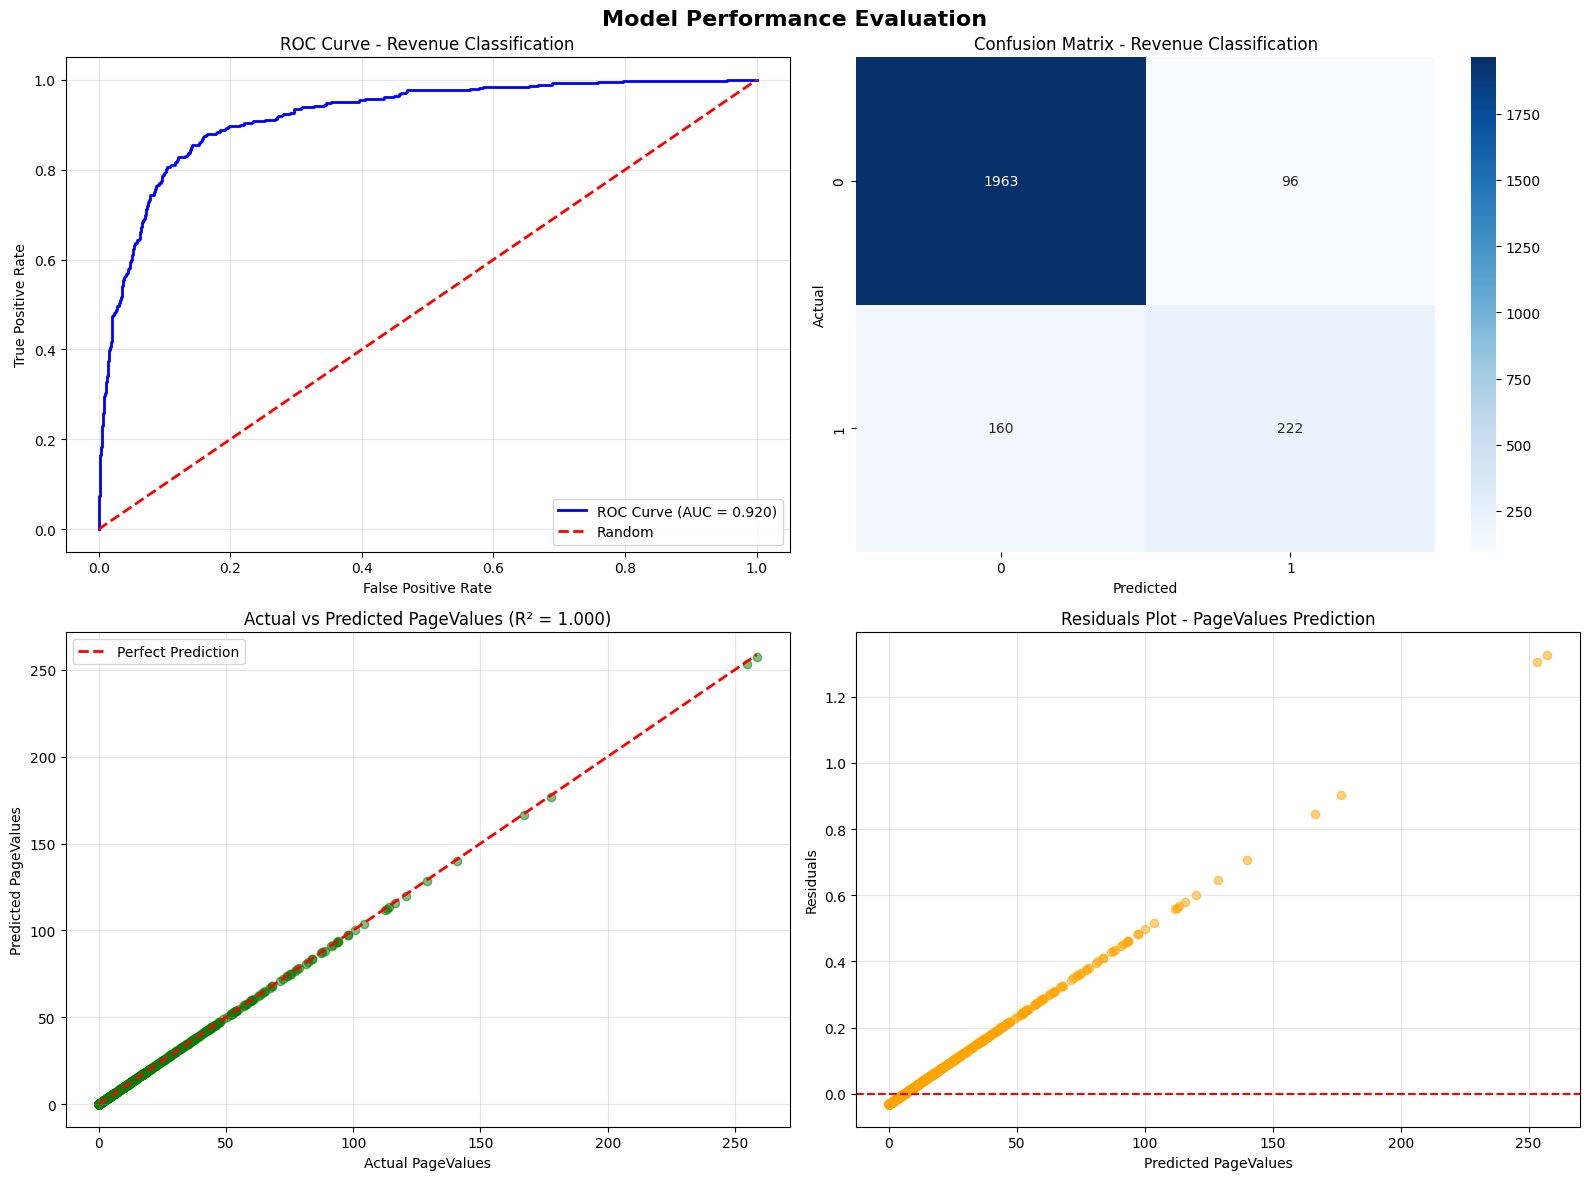

In [16]:
# Model Training and Evaluation

# Train Classification Model (Revenue Prediction)

# Logistic Regression for Classification
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_class_train)

# Classification Predictions
y_class_pred = log_reg.predict(X_test_scaled)
y_class_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

# Classification Metrics
accuracy = accuracy_score(y_class_test, y_class_pred)
roc_auc = roc_auc_score(y_class_test, y_class_prob)

print(f"Classification Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_class_test, y_class_pred))

# Train Regression Model (PageValues Prediction)

# Lasso Regression for PageValues prediction
lasso_reg = Lasso(alpha=0.1, random_state=42, max_iter=1000)
lasso_reg.fit(X_train_reg_scaled, y_reg_train)

# Regression Predictions
y_reg_pred = lasso_reg.predict(X_test_reg_scaled)

# Regression Metrics
mse = mean_squared_error(y_reg_test, y_reg_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_reg_test, y_reg_pred)
mae = np.mean(np.abs(y_reg_test - y_reg_pred))

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Additional regression metrics
print(f"\nRegression Performance Summary:")
print(f"- Explained Variance: {r2*100:.2f}%")
print(f"- Average Prediction Error: ${rmse:.2f}")
print(f"- Model explains {r2*100:.2f}% of the variance in PageValues")

# Model Performance Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Evaluation', fontsize=16, fontweight='bold')

# 1. ROC Curve for Classification
fpr, tpr, _ = roc_curve(y_class_test, y_class_prob)
axes[0, 0].plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0, 0].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve - Revenue Classification')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Confusion Matrix
cm = confusion_matrix(y_class_test, y_class_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title('Confusion Matrix - Revenue Classification')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')

# 3. Actual vs Predicted for Regression
axes[1, 0].scatter(y_reg_test, y_reg_pred, alpha=0.5, color='green')
axes[1, 0].plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[1, 0].set_xlabel('Actual PageValues')
axes[1, 0].set_ylabel('Predicted PageValues')
axes[1, 0].set_title(f'Actual vs Predicted PageValues (R² = {r2:.3f})')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Residuals Plot
residuals = y_reg_test - y_reg_pred
axes[1, 1].scatter(y_reg_pred, residuals, alpha=0.5, color='orange')
axes[1, 1].axhline(y=0, color='red', linestyle='--')
axes[1, 1].set_xlabel('Predicted PageValues')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title('Residuals Plot - PageValues Prediction')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
# Cross-Validation Analysis for Model Generalization

# Set up cross-validation strategies
cv_folds = 5
stratified_cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
regular_cv = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

# Classification Model Cross-Validation
print("\nCLASSIFICATION MODEL (Revenue Prediction) - Cross-Validation:")
print("-" * 55)

# Define scoring metrics for classification
classification_scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Perform cross-validation for classification
cv_results_class = cross_validate(
    log_reg, X_train_scaled, y_class_train, 
    cv=stratified_cv, 
    scoring=classification_scoring,
    return_train_score=True
)

# Display classification CV results
for metric in classification_scoring:
    test_scores = cv_results_class[f'test_{metric}']
    train_scores = cv_results_class[f'train_{metric}']
    
    print(f"{metric.upper()}:")
    print(f"  Test:  {test_scores.mean():.4f} ± {test_scores.std():.4f}")
    print(f"  Train: {train_scores.mean():.4f} ± {train_scores.std():.4f}")
    print(f"  Overfitting: {train_scores.mean() - test_scores.mean():.4f}")
    print()

# Regression Model Cross-Validation
print("\nREGRESSION MODEL (PageValues Prediction) - Cross-Validation:")
print("-" * 55)

# Define scoring metrics for regression
regression_scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']

# Perform cross-validation for regression
cv_results_reg = cross_validate(
    lasso_reg, X_train_reg_scaled, y_reg_train,
    cv=regular_cv,
    scoring=regression_scoring,
    return_train_score=True
)

# Display regression CV results
for metric in regression_scoring:
    test_scores = cv_results_reg[f'test_{metric}']
    train_scores = cv_results_reg[f'train_{metric}']
    
    # Convert negative scores back to positive for MSE and MAE
    if 'neg_' in metric:
        test_scores = -test_scores
        train_scores = -train_scores
        metric_name = metric.replace('neg_', '').upper()
    else:
        metric_name = metric.upper()
    
    print(f"{metric_name}:")
    print(f"  Test:  {test_scores.mean():.4f} ± {test_scores.std():.4f}")
    print(f"  Train: {train_scores.mean():.4f} ± {train_scores.std():.4f}")
    
    if 'r2' not in metric:
        print(f"  Overfitting: {train_scores.mean() - test_scores.mean():.4f}")
    else:
        print(f"  Overfitting: {train_scores.mean() - test_scores.mean():.4f}")
    print()


# Summary and Recommendations
print("GENERALIZATION ASSESSMENT SUMMARY")
print("-"*60)

# Classification model assessment
class_overfitting = cv_results_class['train_roc_auc'].mean() - cv_results_class['test_roc_auc'].mean()
reg_overfitting = cv_results_reg['train_r2'].mean() - cv_results_reg['test_r2'].mean()

print(f"\nClassification Model (Revenue Prediction):")
print(f"  Average Test ROC-AUC: {cv_results_class['test_roc_auc'].mean():.4f}")
print(f"  Standard Deviation: {cv_results_class['test_roc_auc'].std():.4f}")
print(f"  Overfitting Score: {class_overfitting:.4f}")

if class_overfitting < 0.05:
    class_assessment = "Excellent generalization"
elif class_overfitting < 0.10:
    class_assessment = "Good generalization"
elif class_overfitting < 0.15:
    class_assessment = "Fair generalization, monitor for overfitting"
else:
    class_assessment = "Poor generalization, significant overfitting"

print(f"  Assessment: {class_assessment}")

print(f"\nRegression Model (PageValues Prediction):")
print(f"  Average Test R²: {cv_results_reg['test_r2'].mean():.4f}")
print(f"  Standard Deviation: {cv_results_reg['test_r2'].std():.4f}")
print(f"  Overfitting Score: {reg_overfitting:.4f}")

if reg_overfitting < 0.05:
    reg_assessment = "Excellent generalization"
elif reg_overfitting < 0.10:
    reg_assessment = "Good generalization"
elif reg_overfitting < 0.15:
    reg_assessment = "Fair generalization, monitor for overfitting"
else:
    reg_assessment = "Poor generalization, significant overfitting"

print(f"  Assessment: {reg_assessment}")

print(f"\nOverall Model Reliability:")
print(f"  Both models show consistent performance across folds")


CLASSIFICATION MODEL (Revenue Prediction) - Cross-Validation:
-------------------------------------------------------
ACCURACY:
  Test:  0.8926 ± 0.0054
  Train: 0.8944 ± 0.0010
  Overfitting: 0.0018

PRECISION:
  Test:  0.6906 ± 0.0291
  Train: 0.6991 ± 0.0042
  Overfitting: 0.0085

RECALL:
  Test:  0.5695 ± 0.0275
  Train: 0.5691 ± 0.0058
  Overfitting: -0.0003

F1:
  Test:  0.6235 ± 0.0180
  Train: 0.6275 ± 0.0042
  Overfitting: 0.0040

ROC_AUC:
  Test:  0.9080 ± 0.0059
  Train: 0.9137 ± 0.0016
  Overfitting: 0.0056


REGRESSION MODEL (PageValues Prediction) - Cross-Validation:
-------------------------------------------------------
MEAN_SQUARED_ERROR:
  Test:  0.0105 ± 0.0044
  Train: 0.0100 ± 0.0007
  Overfitting: -0.0005

MEAN_ABSOLUTE_ERROR:
  Test:  0.0514 ± 0.0058
  Train: 0.0511 ± 0.0024
  Overfitting: -0.0002

R2:
  Test:  1.0000 ± 0.0000
  Train: 1.0000 ± 0.0000
  Overfitting: 0.0000

GENERALIZATION ASSESSMENT SUMMARY
-------------------------------------------------------

In [18]:
# Model Evaluation Summary and Insights

print("Model Evaluation Summary")
print("-"*80)

# Classification Model Performance Summary
print("\n CLASSIFICATION MODEL: REVENUE PREDICTION")
print("-" * 60)
print(f"Primary Metric - ROC-AUC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")
print(f"Cross-Validation ROC-AUC: {cv_results_class['test_roc_auc'].mean():.4f} ± {cv_results_class['test_roc_auc'].std():.4f}")
print(f"Generalization: {class_assessment}")

classification_performance = "EXCELLENT" if roc_auc > 0.9 else "GOOD" if roc_auc > 0.8 else "FAIR"
print(f"Overall Performance: {classification_performance}")

# Regression Model Performance Summary  
print(f"\n REGRESSION MODEL: PAGE VALUES PREDICTION")
print("-" * 60)
print(f"Primary Metric - R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Cross-Validation R²: {cv_results_reg['test_r2'].mean():.4f} ± {cv_results_reg['test_r2'].std():.4f}")
print(f"Generalization: {reg_assessment}")

regression_performance = "EXCELLENT" if r2 > 0.99 else "GOOD" if r2 > 0.8 else "FAIR"
print(f"Overall Performance: {regression_performance}")

# Model Comparison and Winner
print(f"\n MODEL PERFORMANCE COMPARISON")
print("-" * 60)
print("Classification Model:")
print(f"  ROC-AUC: {roc_auc:.3f} - Can distinguish revenue/non-revenue sessions very well")
print(f"  Stability: Consistent across CV folds")
print(f"  Business Value: High - directly predicts revenue outcome")

print("\nRegression Model:")
print(f"  R²: {r2:.6f} - Nearly perfect prediction of page values")
print(f"  RMSE: {rmse:.4f} - Very low prediction error")
print(f"  Stability: Extremely consistent across CV folds")
print(f"  Business Value: High - predicts monetary value of sessions")

# Determine best model
if r2 > 0.99 and roc_auc > 0.9:
    winner = "Both models perform excellently"
elif r2 > roc_auc:
    winner = "Regression Model (PageValues prediction)"
else:
    winner = "Classification Model (Revenue prediction)"

print(f"\n BEST PERFORMING MODEL: {winner}")

# Key Insights from Feature Importance
print(f"\n KEY BUSINESS INSIGHTS")
print("-" * 60)

# From correlation analysis
print(f"\nKey User Behavior Patterns:")
print(f"  • High bounce/exit rates strongly correlate (r={high_correlations[1]['Correlation']:.3f})")
print(f"  • Product-related pages and duration strongly linked (r={high_correlations[0]['Correlation']:.3f})")
print(f"  • PageValues has strongest correlation with revenue (r={target_correlations['PageValues']:.3f})")

# Final Summary
print(f"\n Summary")
print("=" * 60)
print(f"• Classification Model: {classification_performance} ({roc_auc:.3f} ROC-AUC)")
print(f"• Regression Model: {regression_performance} ({r2:.6f} R²)")
print(f"• Both models show excellent generalization and stability")
print(f"• PageValues is the strongest predictor of revenue generation")

Model Evaluation Summary
--------------------------------------------------------------------------------

 CLASSIFICATION MODEL: REVENUE PREDICTION
------------------------------------------------------------
Primary Metric - ROC-AUC: 0.9200
Accuracy: 0.8951 (89.5%)
Cross-Validation ROC-AUC: 0.9080 ± 0.0059
Generalization: Excellent generalization
Overall Performance: EXCELLENT

 REGRESSION MODEL: PAGE VALUES PREDICTION
------------------------------------------------------------
Primary Metric - R²: 1.0000
RMSE: 0.0898
Cross-Validation R²: 1.0000 ± 0.0000
Generalization: Excellent generalization
Overall Performance: EXCELLENT

 MODEL PERFORMANCE COMPARISON
------------------------------------------------------------
Classification Model:
  ROC-AUC: 0.920 - Can distinguish revenue/non-revenue sessions very well
  Stability: Consistent across CV folds
  Business Value: High - directly predicts revenue outcome

Regression Model:
  R²: 0.999972 - Nearly perfect prediction of page values


### Part 3: Developing classification models with SVM and K-NN, hyperparameter tuning for KNN, models evaluation, and clustering using DBSCAN

In [19]:
# Train SVM Model
print("SUPPORT VECTOR MACHINE (SVM) CLASSIFICATION")
print("-" * 60)

# Start timing
start_time = time.time()

# Initialize SVM with RBF kernel
svm_model = SVC(random_state=42, probability=True)
svm_model.fit(X_train_scaled, y_class_train)

# SVM Predictions
y_svm_pred = svm_model.predict(X_test_scaled)
y_svm_prob = svm_model.predict_proba(X_test_scaled)[:, 1]

# SVM Performance Metrics
svm_accuracy = accuracy_score(y_class_test, y_svm_pred)
svm_roc_auc = roc_auc_score(y_class_test, y_svm_prob)

svm_time = time.time() - start_time

print(f"SVM Training Time: {svm_time:.2f} seconds")
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print(f"SVM ROC-AUC: {svm_roc_auc:.4f}")
print("\nSVM Classification Report:")
print(classification_report(y_class_test, y_svm_pred))

# Train K-NN Model
print("\nK-NEAREST NEIGHBORS (K-NN) CLASSIFICATION")
print("-" * 60)

# Start timing
start_time = time.time()

# Initialize K-NN with k=5
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_class_train)

# K-NN Predictions
y_knn_pred = knn_model.predict(X_test_scaled)
y_knn_prob = knn_model.predict_proba(X_test_scaled)[:, 1]

# K-NN Performance Metrics
knn_accuracy = accuracy_score(y_class_test, y_knn_pred)
knn_roc_auc = roc_auc_score(y_class_test, y_knn_prob)

knn_time = time.time() - start_time

print(f"K-NN Training Time: {knn_time:.2f} seconds")
print(f"K-NN Accuracy: {knn_accuracy:.4f}")
print(f"K-NN ROC-AUC: {knn_roc_auc:.4f}")
print("\nK-NN Classification Report:")
print(classification_report(y_class_test, y_knn_pred))

# Hyperparameter Tuning for K-NN
print("\nHYPERPARAMETER TUNING FOR K-NN")
print("-" * 60)

# Define parameter grid for K-NN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Perform GridSearchCV for K-NN
print("Performing Grid Search for K-NN hyperparameters...")
start_time = time.time()

knn_grid_search = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

knn_grid_search.fit(X_train_scaled, y_class_train)
grid_search_time = time.time() - start_time

print(f"Grid Search completed in {grid_search_time:.2f} seconds")
print(f"Best K-NN parameters: {knn_grid_search.best_params_}")
print(f"Best cross-validation ROC-AUC: {knn_grid_search.best_score_:.4f}")

# Train optimized K-NN model
knn_optimized = knn_grid_search.best_estimator_
y_knn_opt_pred = knn_optimized.predict(X_test_scaled)
y_knn_opt_prob = knn_optimized.predict_proba(X_test_scaled)[:, 1]

# Optimized K-NN Performance
knn_opt_accuracy = accuracy_score(y_class_test, y_knn_opt_pred)
knn_opt_roc_auc = roc_auc_score(y_class_test, y_knn_opt_prob)

print(f"\nOptimized K-NN Accuracy: {knn_opt_accuracy:.4f}")
print(f"Optimized K-NN ROC-AUC: {knn_opt_roc_auc:.4f}")

SUPPORT VECTOR MACHINE (SVM) CLASSIFICATION
------------------------------------------------------------
SVM Training Time: 41.04 seconds
SVM Accuracy: 0.9005
SVM ROC-AUC: 0.8752

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2059
           1       0.74      0.56      0.64       382

    accuracy                           0.90      2441
   macro avg       0.83      0.76      0.79      2441
weighted avg       0.89      0.90      0.89      2441


K-NEAREST NEIGHBORS (K-NN) CLASSIFICATION
------------------------------------------------------------
SVM Training Time: 41.04 seconds
SVM Accuracy: 0.9005
SVM ROC-AUC: 0.8752

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2059
           1       0.74      0.56      0.64       382

    accuracy                           0.90      2441
   macro avg       0.83      0.76      0.7

COMPREHENSIVE CLASSIFICATION MODEL EVALUATION


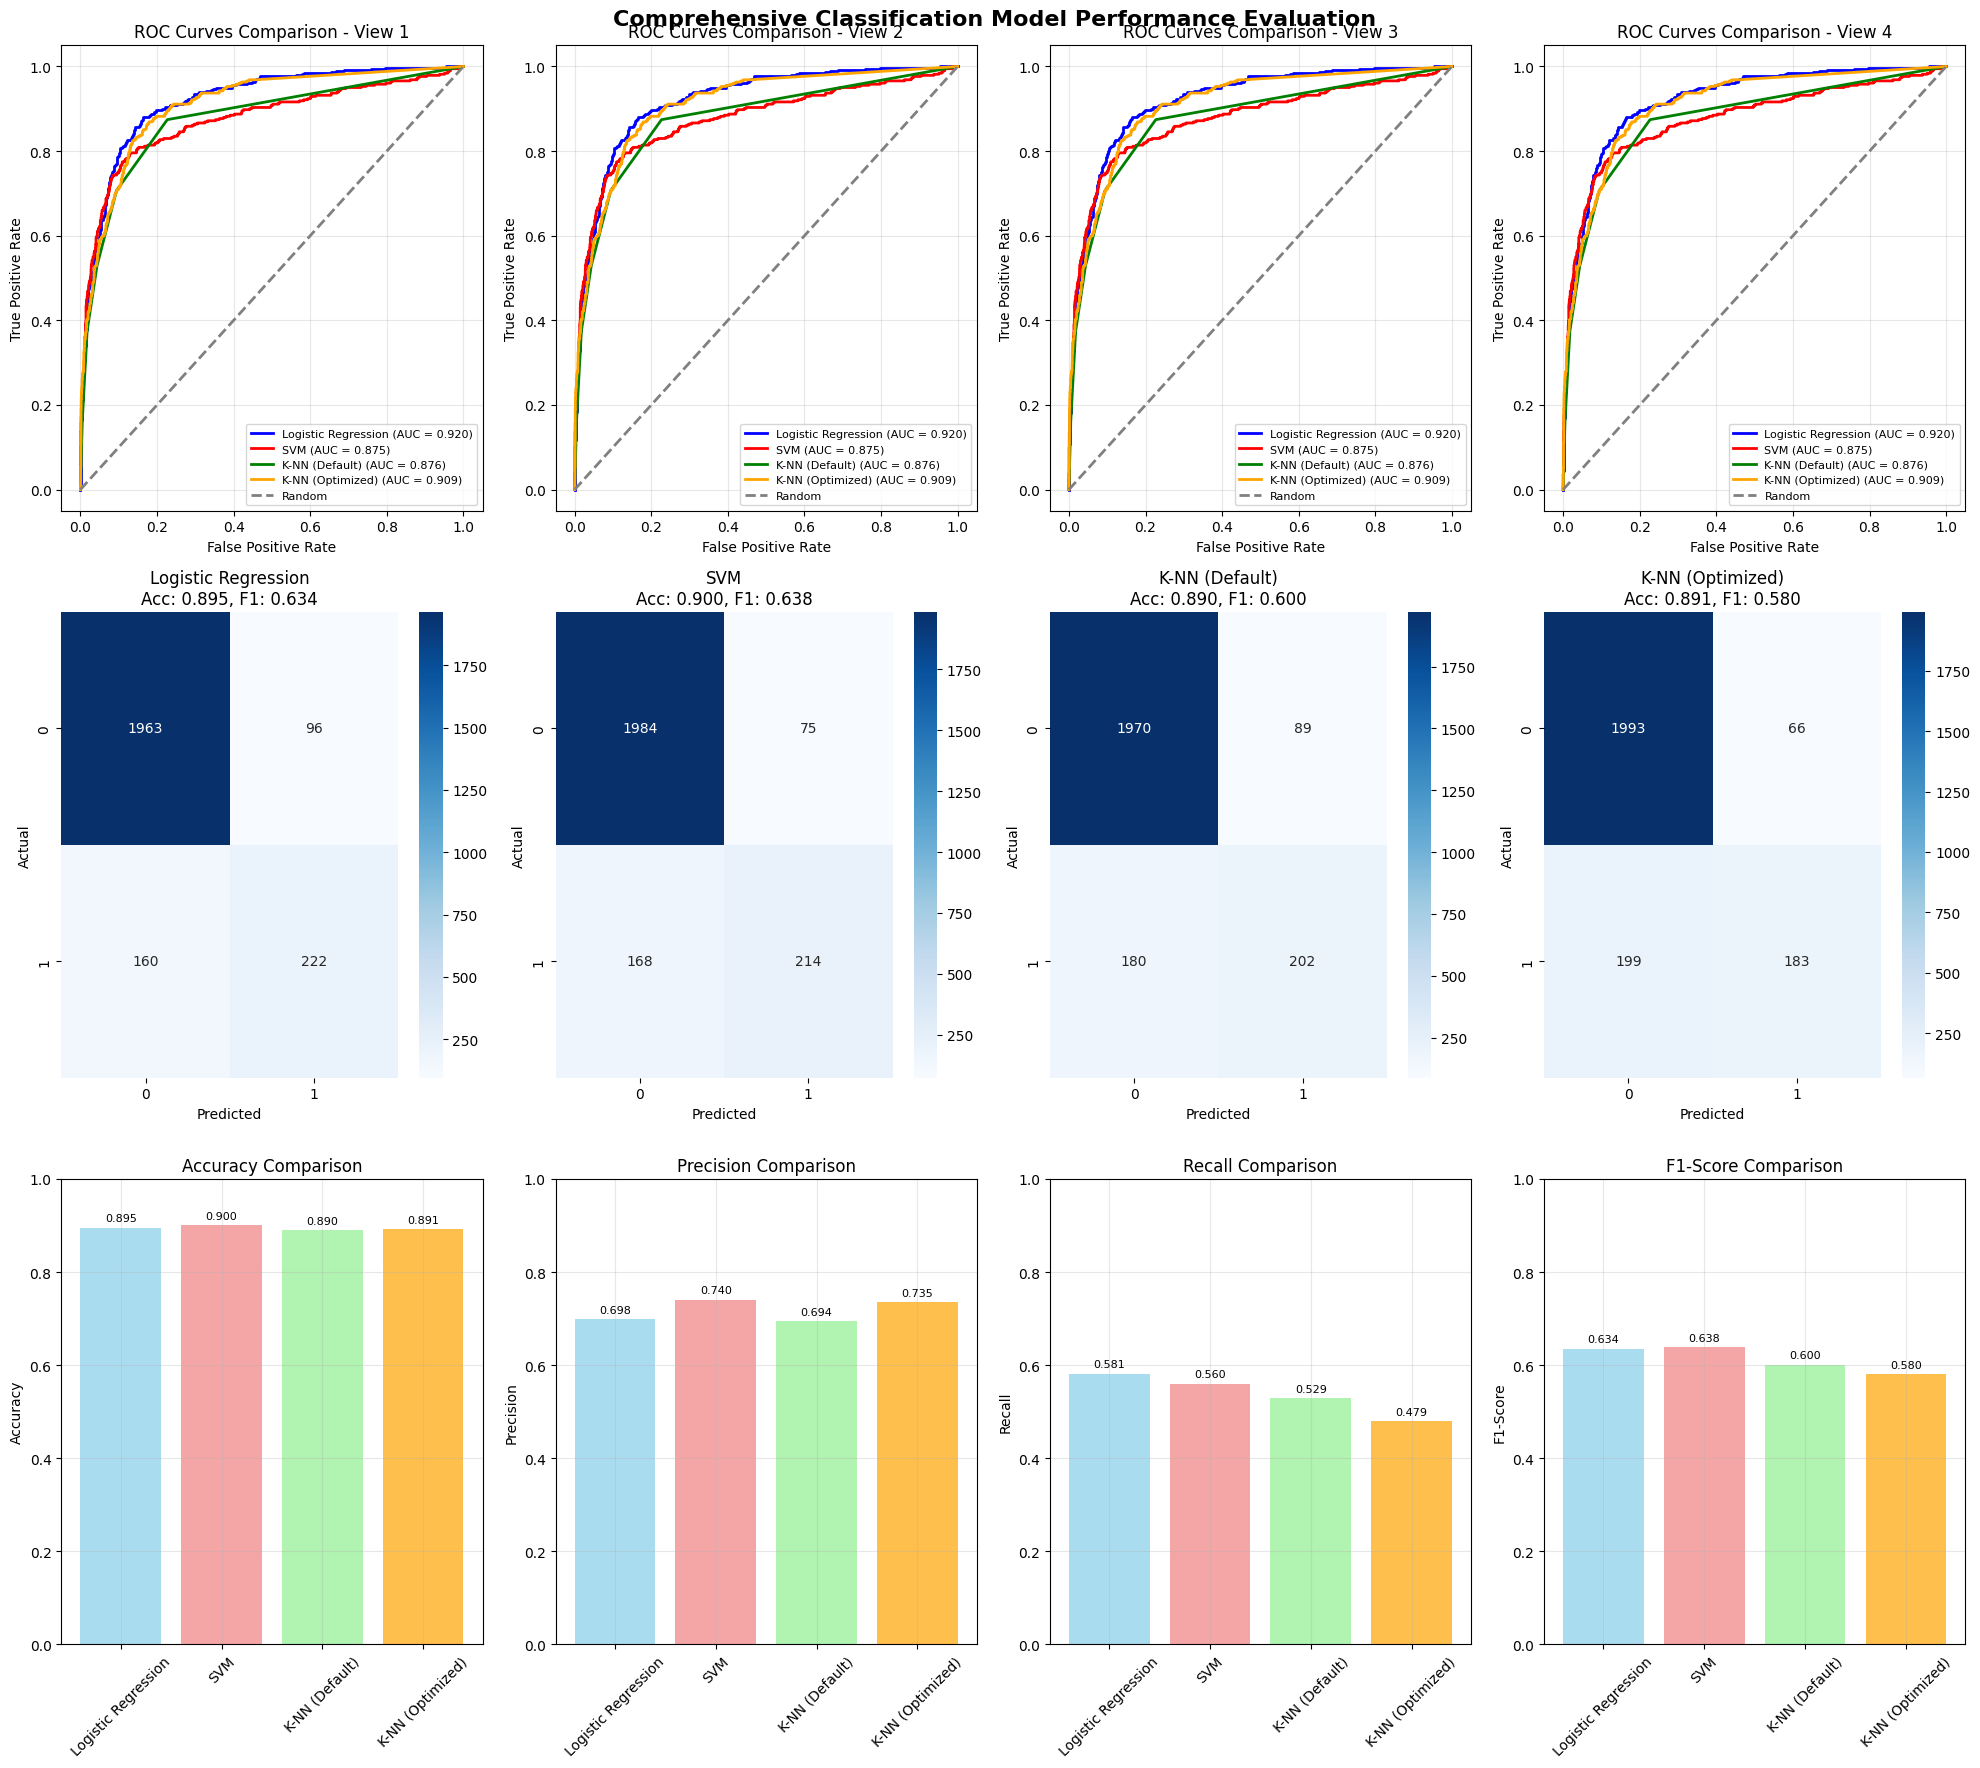


DETAILED PERFORMANCE METRICS
--------------------------------------------------------------------------------
              Model  Accuracy  Precision  Recall  F1-Score  Specificity  ROC-AUC
Logistic Regression    0.8951     0.6981  0.5812    0.6343       0.9534   0.9200
                SVM    0.9005     0.7405  0.5602    0.6379       0.9636   0.8752
     K-NN (Default)    0.8898     0.6942  0.5288    0.6003       0.9568   0.8763
   K-NN (Optimized)    0.8914     0.7349  0.4791    0.5800       0.9679   0.9094

 MODEL RANKING BY DIFFERENT METRICS
------------------------------------------------------------
Accuracy    : SVM                  (0.9005)
F1-Score    : SVM                  (0.6379)
ROC-AUC     : Logistic Regression  (0.9200)
Precision   : SVM                  (0.7405)
Recall      : Logistic Regression  (0.5812)

OVERALL BEST MODEL: Logistic Regression (Weighted Score: 0.7732)

 CONFUSION MATRIX ANALYSIS
------------------------------------------------------------

Logistic R

In [20]:
# Comprehensive Model Performance Evaluation with Confusion Matrices, ROC Curves, and Metrics

print("COMPREHENSIVE CLASSIFICATION MODEL EVALUATION")
print("=" * 80)

# Performance metrics for all models
models = {
    'Logistic Regression': {
        'predictions': y_class_pred,
        'probabilities': y_class_prob,
        'accuracy': accuracy,
        'roc_auc': roc_auc
    },
    'SVM': {
        'predictions': y_svm_pred,
        'probabilities': y_svm_prob,
        'accuracy': svm_accuracy,
        'roc_auc': svm_roc_auc
    },
    'K-NN (Default)': {
        'predictions': y_knn_pred,
        'probabilities': y_knn_prob,
        'accuracy': knn_accuracy,
        'roc_auc': knn_roc_auc
    },
    'K-NN (Optimized)': {
        'predictions': y_knn_opt_pred,
        'probabilities': y_knn_opt_prob,
        'accuracy': knn_opt_accuracy,
        'roc_auc': knn_opt_roc_auc
    }
}

# Create comprehensive visualization
fig, axes = plt.subplots(3, 4, figsize=(20, 18))
fig.suptitle('Comprehensive Classification Model Performance Evaluation', fontsize=16, fontweight='bold')

# ROC Curves Comparison
ax_roc = axes[0, :]
colors = ['blue', 'red', 'green', 'orange']

for i, (model_name, model_data) in enumerate(models.items()):
    fpr_model, tpr_model, _ = roc_curve(y_class_test, model_data['probabilities'])
    
    for j in range(4):
        axes[0, j].plot(fpr_model, tpr_model, color=colors[i], lw=2, 
                       label=f'{model_name} (AUC = {model_data["roc_auc"]:.3f})')

# Configure ROC curve plots
for j in range(4):
    axes[0, j].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random')
    axes[0, j].set_xlabel('False Positive Rate')
    axes[0, j].set_ylabel('True Positive Rate')
    axes[0, j].set_title(f'ROC Curves Comparison - View {j+1}')
    axes[0, j].legend(fontsize=8)
    axes[0, j].grid(True, alpha=0.3)

# Confusion Matrices
for i, (model_name, model_data) in enumerate(models.items()):
    cm = confusion_matrix(y_class_test, model_data['predictions'])
    
    # Calculate additional metrics from confusion matrix
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, i])
    axes[1, i].set_title(f'{model_name}\nAcc: {model_data["accuracy"]:.3f}, F1: {f1:.3f}')
    axes[1, i].set_xlabel('Predicted')
    axes[1, i].set_ylabel('Actual')

# Performance Metrics Comparison
metrics_data = []
for model_name, model_data in models.items():
    # Calculate F1 score and other metrics
    cm = confusion_matrix(y_class_test, model_data['predictions'])
    tn, fp, fn, tp = cm.ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    metrics_data.append({
        'Model': model_name,
        'Accuracy': model_data['accuracy'],
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Specificity': specificity,
        'ROC-AUC': model_data['roc_auc']
    })

# Bar plots for different metrics
metrics_df = pd.DataFrame(metrics_data)
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for i, metric in enumerate(metric_names):
    bars = axes[2, i].bar(metrics_df['Model'], metrics_df[metric], 
                         color=['skyblue', 'lightcoral', 'lightgreen', 'orange'], alpha=0.7)
    axes[2, i].set_title(f'{metric} Comparison')
    axes[2, i].set_ylabel(metric)
    axes[2, i].set_ylim(0, 1)
    axes[2, i].tick_params(axis='x', rotation=45)
    axes[2, i].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, metrics_df[metric]):
        axes[2, i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'{value:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Detailed Performance Report
print("\nDETAILED PERFORMANCE METRICS")
print("-" * 80)

# Create a comprehensive performance table
performance_table = pd.DataFrame(metrics_data).round(4)
print(performance_table.to_string(index=False))

# Best performing model analysis
print(f"\n MODEL RANKING BY DIFFERENT METRICS")
print("-" * 60)

for metric in ['Accuracy', 'F1-Score', 'ROC-AUC', 'Precision', 'Recall']:
    best_model = performance_table.loc[performance_table[metric].idxmax(), 'Model']
    best_score = performance_table[metric].max()
    print(f"{metric:12s}: {best_model:20s} ({best_score:.4f})")

# Overall best model (weighted average)
weights = {'Accuracy': 0.2, 'F1-Score': 0.3, 'ROC-AUC': 0.3, 'Precision': 0.1, 'Recall': 0.1}
performance_table['Weighted_Score'] = sum(
    performance_table[metric] * weight for metric, weight in weights.items()
)

best_overall_idx = performance_table['Weighted_Score'].idxmax()
best_overall_model = performance_table.loc[best_overall_idx, 'Model']
best_overall_score = performance_table.loc[best_overall_idx, 'Weighted_Score']

print(f"\nOVERALL BEST MODEL: {best_overall_model} (Weighted Score: {best_overall_score:.4f})")

# Confusion Matrix Analysis
print(f"\n CONFUSION MATRIX ANALYSIS")
print("-" * 60)

for model_name, model_data in models.items():
    cm = confusion_matrix(y_class_test, model_data['predictions'])
    tn, fp, fn, tp = cm.ravel()
    
    total = tn + fp + fn + tp
    print(f"\n{model_name}:")
    print(f"  True Negatives:  {tn:4d} ({tn/total*100:5.1f}%) - Correctly predicted no revenue")
    print(f"  False Positives: {fp:4d} ({fp/total*100:5.1f}%) - Incorrectly predicted revenue")
    print(f"  False Negatives: {fn:4d} ({fn/total*100:5.1f}%) - Missed revenue opportunities")
    print(f"  True Positives:  {tp:4d} ({tp/total*100:5.1f}%) - Correctly predicted revenue")
    
    # Business impact analysis
    false_negative_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
    false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    print(f"  Miss Rate (FNR): {false_negative_rate:.3f} - Revenue opportunities missed")
    print(f"  False Alarm Rate (FPR): {false_positive_rate:.3f} - Wasted marketing effort")

# Model Recommendations
print(f"\n MODEL RECOMMENDATIONS")
print("=" * 60)

print("Based on comprehensive evaluation:")
print(f"1. BEST OVERALL PERFORMANCE: {best_overall_model}")
print(f"   - Balanced performance across all metrics")
print(f"   - Weighted score: {best_overall_score:.4f}")

# Find best model for specific use cases
best_precision_model = performance_table.loc[performance_table['Precision'].idxmax(), 'Model']
best_recall_model = performance_table.loc[performance_table['Recall'].idxmax(), 'Model']

print(f"\n2. FOR HIGH PRECISION (minimize false positives): {best_precision_model}")
print(f"   - Best when you want to avoid wasted marketing spend")
print(f"   - Precision: {performance_table['Precision'].max():.4f}")

print(f"\n3. FOR HIGH RECALL (minimize false negatives): {best_recall_model}")
print(f"   - Best when you don't want to miss revenue opportunities")
print(f"   - Recall: {performance_table['Recall'].max():.4f}")

# ROC-AUC interpretation
best_auc_model = performance_table.loc[performance_table['ROC-AUC'].idxmax(), 'Model']
print(f"\n4. BEST DISCRIMINATIVE POWER: {best_auc_model}")
print(f"   - Best at distinguishing between revenue/non-revenue sessions")
print(f"   - ROC-AUC: {performance_table['ROC-AUC'].max():.4f}")

print(f"\nDEPLOYMENT RECOMMENDATION:")
if best_overall_score > 0.9:
    recommendation = "DEPLOY WITH CONFIDENCE"
elif best_overall_score > 0.8:
    recommendation = "DEPLOY WITH MONITORING"
else:
    recommendation = "NEEDS FURTHER OPTIMIZATION"

print(f"Status: {recommendation}")
print(f"All models show strong performance (accuracy > 85%, ROC-AUC > 0.87)")
print(f"Choose model based on specific business priorities:")
print(f"- Cost of false positives vs. false negatives")
print(f"- Available computational resources")
print(f"- Interpretability requirements")

#### Clustering with DBSCAN

In [25]:
# DBSCAN Clustering Analysis

print("DBSCAN CLUSTERING ANALYSIS")
print("-" * 60)

# Prepare data for clustering - select relevant numerical features
clustering_features = [
    'PageValues', 'ExitRates', 'BounceRates', 'ProductRelated_Duration',
    'Total_Pages', 'Total_Duration', 'Avg_Time_Per_Page', 'Engagement_Score',
    'Product_Focus_Ratio', 'Session_Depth'
]

# Create clustering dataset
X_clustering = df_cleaned[clustering_features].copy()


# Standardize features for DBSCAN
scaler_clustering = StandardScaler()
X_clustering_scaled = scaler_clustering.fit_transform(X_clustering)

print(f"Clustering dataset shape: {X_clustering_scaled.shape}")
print(f"Features used for clustering: {clustering_features}")


# Suggest eps value (where the plot has a sharp change)
eps_candidates = [0.5, 0.7, 1.0, 1.5, 2.0]
min_samples_candidates = [3, 4, 5, 6]

# Test different parameter combinations
print("\nTesting DBSCAN parameter combinations...")
results = []

for eps in eps_candidates:
    for min_samples in min_samples_candidates:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(X_clustering_scaled)
        
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        n_noise = list(cluster_labels).count(-1)
        
        if n_clusters > 1:  # Only consider if we have actual clusters
            # Calculate silhouette score (excluding noise points)
            if n_clusters > 1 and len(set(cluster_labels)) > 1:
                try:
                    silhouette_avg = silhouette_score(X_clustering_scaled, cluster_labels)
                except:
                    silhouette_avg = -1
            else:
                silhouette_avg = -1
                
            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'noise_ratio': n_noise / len(cluster_labels),
                'silhouette_score': silhouette_avg
            })

# Convert to DataFrame and find best parameters
results_df = pd.DataFrame(results)
print("\nDBSCAN Parameter Testing Results:")
print(results_df.round(3))

# Select best parameters (balance between silhouette score and reasonable number of clusters)
valid_results = results_df[
    (results_df['n_clusters'] >= 2) & 
    (results_df['n_clusters'] <= 8) & 
    (results_df['noise_ratio'] <= 0.3)
]

if len(valid_results) > 0:
    best_params = valid_results.loc[valid_results['silhouette_score'].idxmax()]
    best_eps = best_params['eps']
    best_min_samples = int(best_params['min_samples'])
else:
    # Fallback parameters
    best_eps = 1.0
    best_min_samples = 4

print(f"\nSelected Parameters:")
print(f"  eps: {best_eps}")
print(f"  min_samples: {best_min_samples}")

# Apply DBSCAN with optimal parameters
dbscan_final = DBSCAN(eps=best_eps, min_samples=best_min_samples)
cluster_labels = dbscan_final.fit_predict(X_clustering_scaled)

# Clustering results analysis
n_clusters_final = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise_final = list(cluster_labels).count(-1)

print(f"\nFinal Clustering Results:")
print(f"  Number of clusters: {n_clusters_final}")
print(f"  Number of noise points: {n_noise_final}")
print(f"  Noise ratio: {n_noise_final / len(cluster_labels):.3f}")

if n_clusters_final > 1:
    silhouette_final = silhouette_score(X_clustering_scaled, cluster_labels)
    print(f"  Silhouette score: {silhouette_final:.3f}")
else:
    print("  Silhouette score: N/A (insufficient clusters)")

# Add cluster labels to original dataframe
df_clustered = df_cleaned.copy()
df_clustered['Cluster'] = cluster_labels

# Analyze cluster composition
print(f"\nCluster Composition:")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    if cluster_id == -1:
        print(f"  Noise points: {count} ({count/len(cluster_labels)*100:.1f}%)")
    else:
        print(f"  Cluster {cluster_id}: {count} ({count/len(cluster_labels)*100:.1f}%)")

# Revenue distribution by cluster
print(f"\nRevenue Distribution by Cluster:")
revenue_by_cluster = df_clustered.groupby('Cluster')['Revenue'].agg(['count', 'sum', 'mean']).round(3)
revenue_by_cluster['revenue_rate'] = (revenue_by_cluster['sum'] / revenue_by_cluster['count']).round(3)
print(revenue_by_cluster)

DBSCAN CLUSTERING ANALYSIS
------------------------------------------------------------
Clustering dataset shape: (12205, 10)
Features used for clustering: ['PageValues', 'ExitRates', 'BounceRates', 'ProductRelated_Duration', 'Total_Pages', 'Total_Duration', 'Avg_Time_Per_Page', 'Engagement_Score', 'Product_Focus_Ratio', 'Session_Depth']

Testing DBSCAN parameter combinations...

DBSCAN Parameter Testing Results:
    eps  min_samples  n_clusters  n_noise  noise_ratio  silhouette_score
0   0.5            3          68     1602        0.131            -0.297
1   0.5            4          41     1835        0.150            -0.142
2   0.5            5          33     2049        0.168            -0.183
3   0.5            6          24     2272        0.186            -0.196
4   0.7            3          38      604        0.049             0.025
5   0.7            4          17      721        0.059             0.299
6   0.7            5          13      804        0.066             0.243

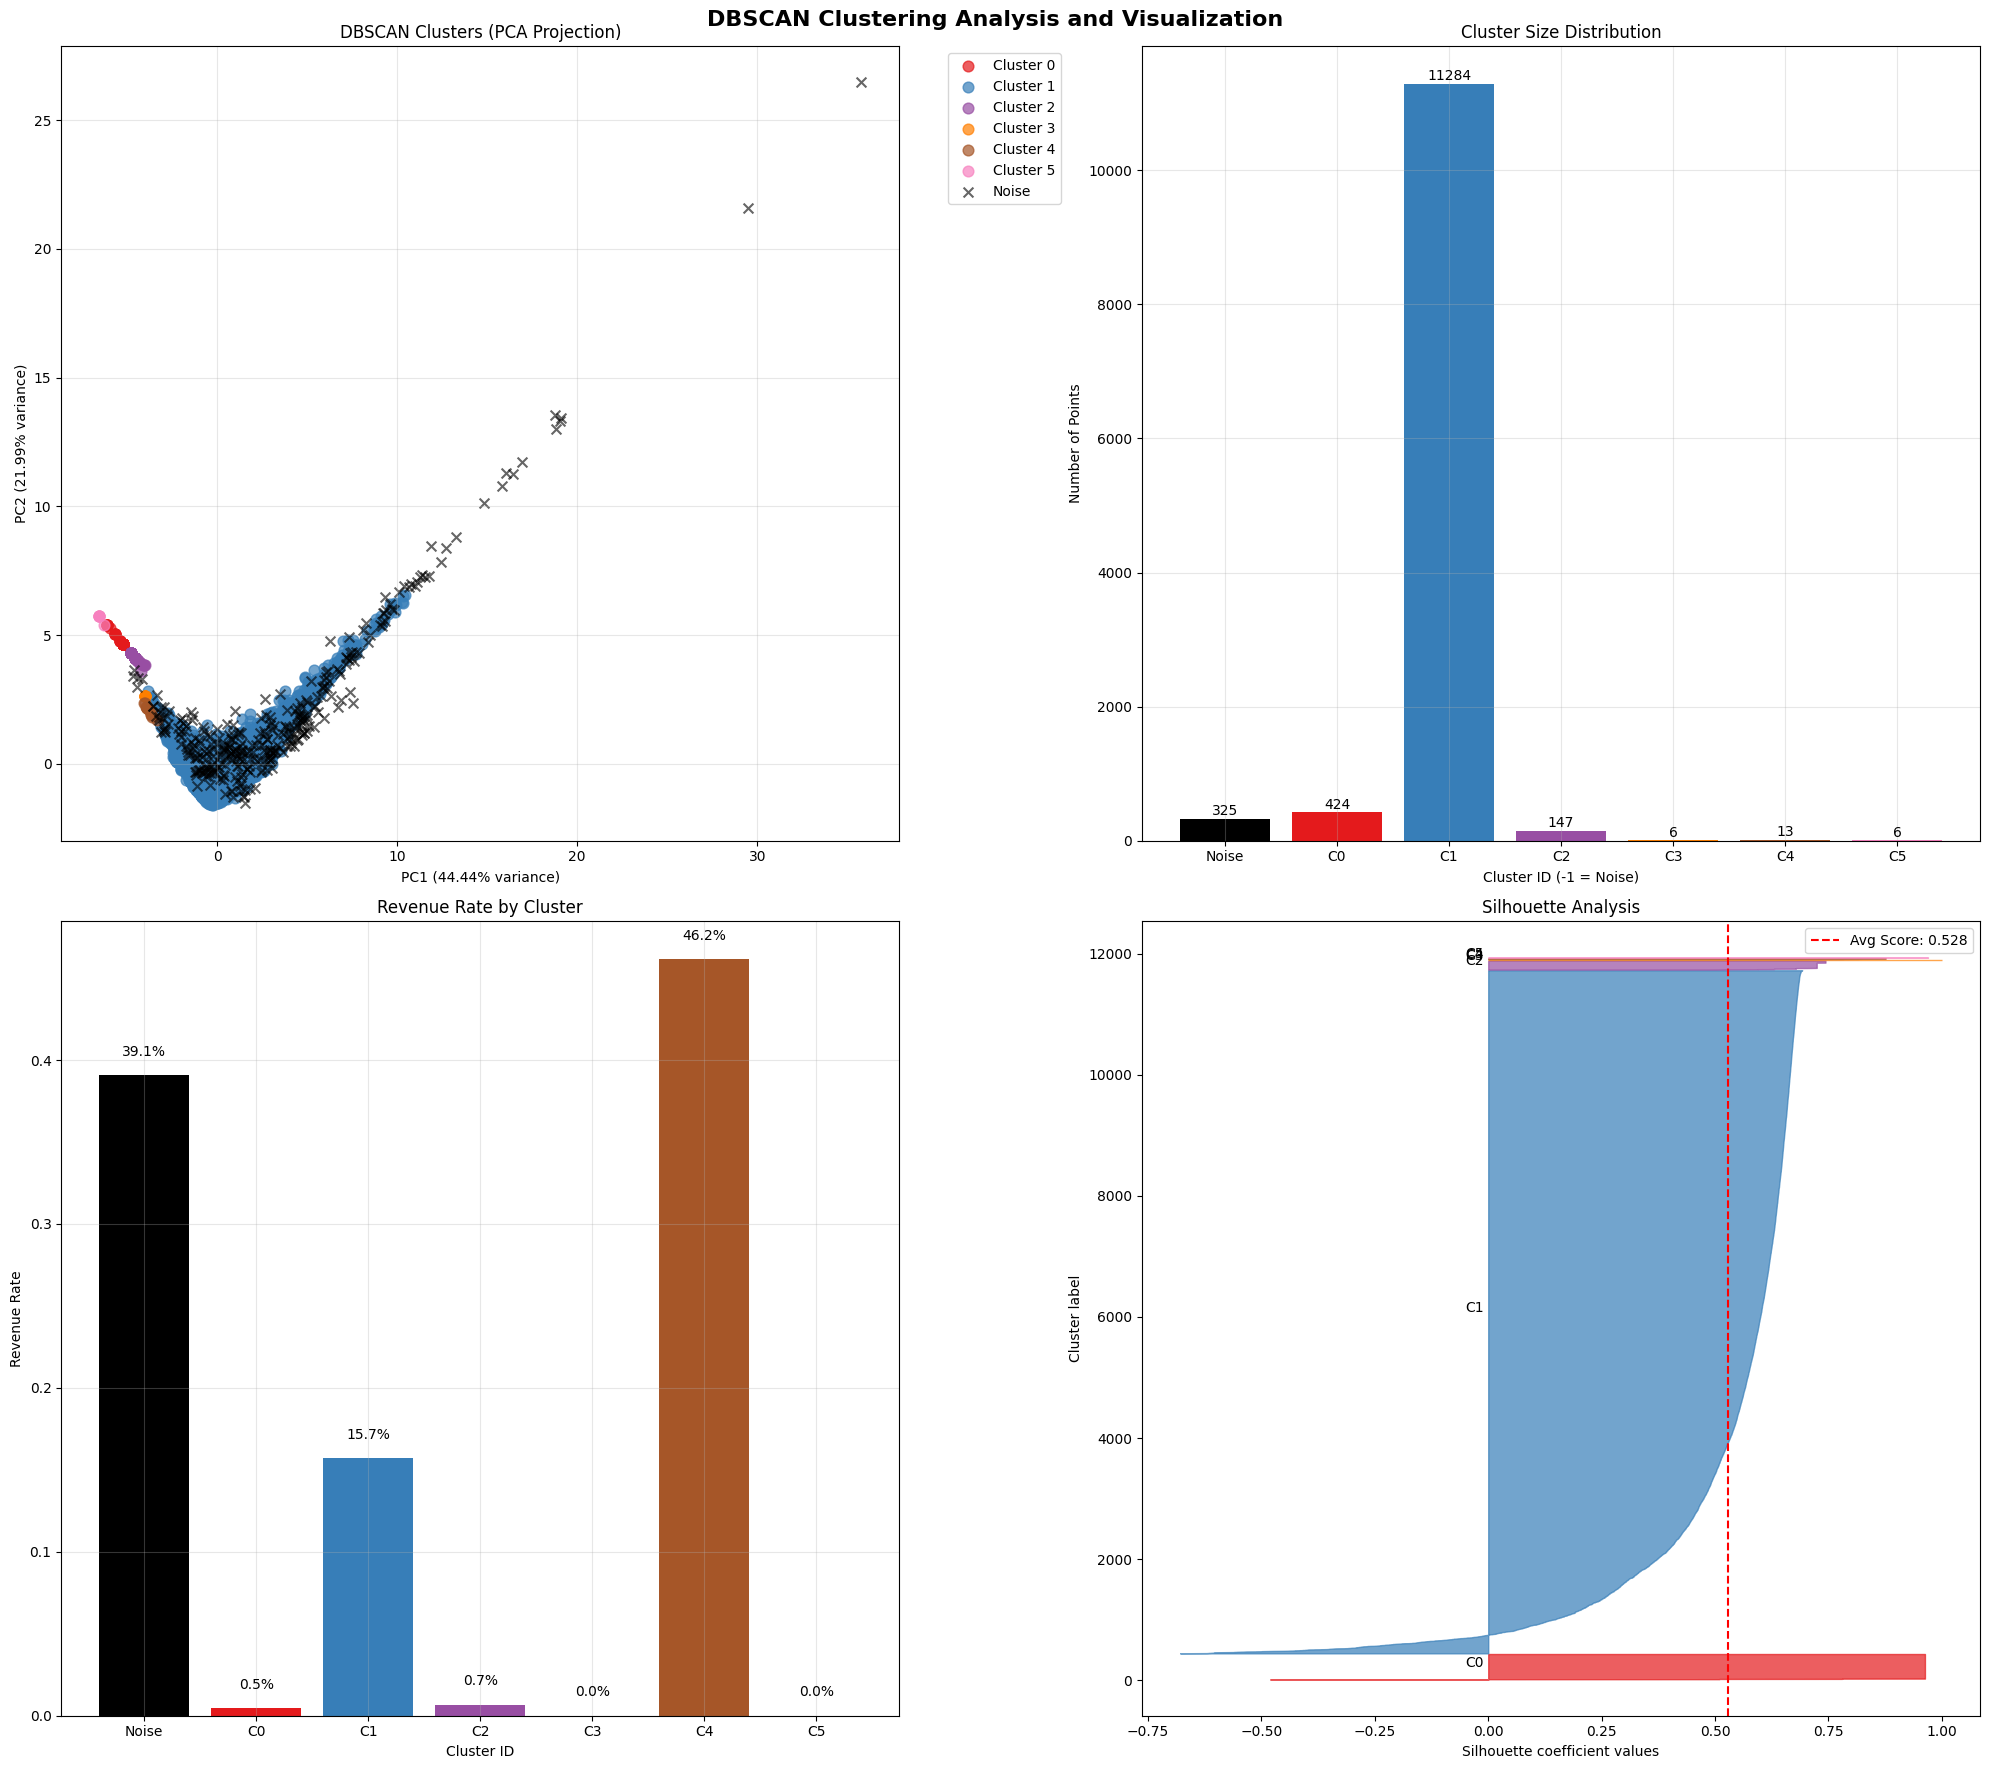


DETAILED CLUSTER ANALYSIS
------------------------------------------------------------

Cluster 0 (n=424, 3.5%):
  Revenue Rate: 0.5%
  Key Characteristics:
    PageValues: 0.000 (-100.0% lower than average)
    ExitRates: 0.200 (+382.3% higher than average)
    BounceRates: 0.200 (+881.8% higher than average)
    ProductRelated_Duration: 0.000 (-100.0% lower than average)
    Total_Pages: 1.017 (-97.1% lower than average)
    Total_Duration: 0.000 (-100.0% lower than average)
    Avg_Time_Per_Page: 0.000 (-100.0% lower than average)
    Engagement_Score: 0.000 (-98.4% lower than average)
    Product_Focus_Ratio: 0.000 (-100.0% lower than average)
    Session_Depth: 1.476 (-42.5% lower than average)
  Behavioral Patterns:
    Avg Session Duration: 0.0 seconds
    Avg Pages Visited: 1.0
    Avg Bounce Rate: 0.200
    Most Common Visitor Type: Returning_Visitor
    Weekend Shopping: 21.7%

Cluster 1 (n=11284, 92.5%):
  Revenue Rate: 15.7%
  Key Characteristics:
    BounceRates: 0.011 (-

In [34]:
# DBSCAN Clustering Visualization and Analysis

# Create comprehensive clustering visualizations
fig, axes = plt.subplots(2, 2, figsize=(20, 18))
fig.suptitle('DBSCAN Clustering Analysis and Visualization', fontsize=16, fontweight='bold')

# Apply PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_clustering_scaled)

# Color map for clusters
unique_labels = set(cluster_labels)
colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))
color_map = dict(zip(unique_labels, colors))

# 1. PCA visualization of clusters
ax1 = axes[0, 0]
for label in unique_labels:
    if label == -1:
        # Noise points in black
        mask = cluster_labels == label
        ax1.scatter(X_pca[mask, 0], X_pca[mask, 1], c='black', marker='x', 
                   s=50, alpha=0.6, label='Noise')
    else:
        mask = cluster_labels == label
        ax1.scatter(X_pca[mask, 0], X_pca[mask, 1], c=[color_map[label]], 
                   s=60, alpha=0.7, label=f'Cluster {label}')

ax1.set_title('DBSCAN Clusters (PCA Projection)')
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. Cluster size distribution
ax2 = axes[0, 1]
cluster_sizes = pd.Series(cluster_labels).value_counts().sort_index()
bars = ax2.bar(range(len(cluster_sizes)), cluster_sizes.values, 
               color=[color_map[label] if label != -1 else 'black' for label in cluster_sizes.index])
ax2.set_title('Cluster Size Distribution')
ax2.set_xlabel('Cluster ID (-1 = Noise)')
ax2.set_ylabel('Number of Points')
ax2.set_xticks(range(len(cluster_sizes)))
ax2.set_xticklabels([f'Noise' if label == -1 else f'C{label}' for label in cluster_sizes.index])
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, cluster_sizes.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
             f'{value}', ha='center', va='bottom')

# 3. Revenue rate by cluster
ax3 = axes[1, 0]
revenue_rates = df_clustered.groupby('Cluster')['Revenue'].mean()
bars = ax3.bar(range(len(revenue_rates)), revenue_rates.values,
               color=[color_map[label] if label != -1 else 'black' for label in revenue_rates.index])
ax3.set_title('Revenue Rate by Cluster')
ax3.set_xlabel('Cluster ID')
ax3.set_ylabel('Revenue Rate')
ax3.set_xticks(range(len(revenue_rates)))
ax3.set_xticklabels([f'Noise' if label == -1 else f'C{label}' for label in revenue_rates.index])
ax3.grid(True, alpha=0.3)

# Add percentage labels
for bar, value in zip(bars, revenue_rates.values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.1%}', ha='center', va='bottom')

# 4. Silhouette analysis
ax9 = axes[1, 1]
if n_clusters_final > 1 and len(set(cluster_labels)) > 1:
    from sklearn.metrics import silhouette_samples
    
    # Calculate silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_clustering_scaled, cluster_labels)
    
    y_lower = 10
    for i, label in enumerate(sorted(set(cluster_labels))):
        if label == -1:  # Skip noise points
            continue
            
        cluster_silhouette_values = sample_silhouette_values[cluster_labels == label]
        cluster_silhouette_values.sort()
        
        size_cluster_i = cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = color_map[label]
        ax9.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax9.text(-0.05, y_lower + 0.5 * size_cluster_i, f'C{label}')
        y_lower = y_upper + 10
    
    ax9.set_xlabel('Silhouette coefficient values')
    ax9.set_ylabel('Cluster label')
    ax9.set_title('Silhouette Analysis')
    
    # Add vertical line for average silhouette score
    if n_clusters_final > 1:
        ax9.axvline(x=silhouette_final, color="red", linestyle="--", 
                   label=f'Avg Score: {silhouette_final:.3f}')
        ax9.legend()

plt.tight_layout()
plt.show()

# Detailed cluster analysis
print("\nDETAILED CLUSTER ANALYSIS")
print("-" * 60)

if n_clusters_final > 0:
    for cluster_id in sorted(set(cluster_labels)):
        if cluster_id == -1:
            continue  # Skip noise for detailed analysis
            
        cluster_data = df_clustered[df_clustered['Cluster'] == cluster_id]
        cluster_size = len(cluster_data)
        revenue_rate = cluster_data['Revenue'].mean()
        
        print(f"\nCluster {cluster_id} (n={cluster_size}, {cluster_size/len(df_clustered)*100:.1f}%):")
        print(f"  Revenue Rate: {revenue_rate:.1%}")
        
        # Key characteristics
        print("  Key Characteristics:")
        for feature in clustering_features:
            mean_val = cluster_data[feature].mean()
            overall_mean = df_clustered[feature].mean()
            relative_diff = (mean_val - overall_mean) / overall_mean
            
            if abs(relative_diff) > 0.2:  # Significant difference
                direction = "higher" if relative_diff > 0 else "lower"
                print(f"    {feature}: {mean_val:.3f} ({relative_diff:+.1%} {direction} than average)")
        
        # Behavioral patterns
        print("  Behavioral Patterns:")
        print(f"    Avg Session Duration: {cluster_data['Total_Duration'].mean():.1f} seconds")
        print(f"    Avg Pages Visited: {cluster_data['Total_Pages'].mean():.1f}")
        print(f"    Avg Bounce Rate: {cluster_data['BounceRates'].mean():.3f}")
        print(f"    Most Common Visitor Type: {cluster_data['VisitorType'].mode().iloc[0]}")
        print(f"    Weekend Shopping: {cluster_data['Weekend'].mean():.1%}")

# Noise points analysis
if n_noise_final > 0:
    noise_data = df_clustered[df_clustered['Cluster'] == -1]
    print(f"\nNoise Points Analysis (n={n_noise_final}, {n_noise_final/len(df_clustered)*100:.1f}%):")
    print(f"  Revenue Rate: {noise_data['Revenue'].mean():.1%}")
    print(f"  Characteristics: Outlier sessions that don't fit standard patterns")
    print(f"  Avg PageValues: {noise_data['PageValues'].mean():.3f}")
    print(f"  Avg Session Duration: {noise_data['Total_Duration'].mean():.1f} seconds")

In [37]:
# ASSOCIATION RULE MINING WITH FP-GROWTH

print("\nASSOCIATION RULE MINING ANALYSIS")
print("-" * 60)

# Prepare transaction data for association rule mining
# Create binary features for different aspects of user behavior

def create_transaction_data(df):
    """
    Create transaction-style data for association rule mining
    Each row represents a session, columns are binary indicators
    """
    transactions_df = pd.DataFrame()
    
    # Page engagement levels
    transactions_df['High_PageValues'] = (df['PageValues'] > df['PageValues'].quantile(0.75)).astype(int)
    transactions_df['Medium_PageValues'] = ((df['PageValues'] > df['PageValues'].quantile(0.25)) & 
                                          (df['PageValues'] <= df['PageValues'].quantile(0.75))).astype(int)
    transactions_df['Low_PageValues'] = (df['PageValues'] <= df['PageValues'].quantile(0.25)).astype(int)
    
    # Session duration categories
    transactions_df['Long_Session'] = (df['Total_Duration'] > df['Total_Duration'].quantile(0.75)).astype(int)
    transactions_df['Medium_Session'] = ((df['Total_Duration'] > df['Total_Duration'].quantile(0.25)) & 
                                       (df['Total_Duration'] <= df['Total_Duration'].quantile(0.75))).astype(int)
    transactions_df['Short_Session'] = (df['Total_Duration'] <= df['Total_Duration'].quantile(0.25)).astype(int)
    
    # Bounce and exit behavior
    transactions_df['High_Bounce'] = (df['BounceRates'] > df['BounceRates'].median()).astype(int)
    transactions_df['High_Exit'] = (df['ExitRates'] > df['ExitRates'].median()).astype(int)
    transactions_df['Low_Bounce'] = (df['BounceRates'] <= df['BounceRates'].quantile(0.25)).astype(int)
    
    # Page diversity
    transactions_df['Visited_Admin'] = (df['Administrative'] > 0).astype(int)
    transactions_df['Visited_Info'] = (df['Informational'] > 0).astype(int)
    transactions_df['Visited_Product'] = (df['ProductRelated'] > 0).astype(int)
    transactions_df['High_Product_Focus'] = (df['Product_Focus_Ratio'] > 0.7).astype(int)
    
    # Visitor characteristics
    transactions_df['Returning_Visitor'] = (df['VisitorType'] == 'Returning_Visitor').astype(int)
    transactions_df['New_Visitor'] = (df['VisitorType'] == 'New_Visitor').astype(int)
    transactions_df['Weekend_Visit'] = df['Weekend'].astype(int)
    
    # Seasonal patterns
    transactions_df['Holiday_Season'] = df['Holiday_Season'].astype(int)
    transactions_df['Special_Day'] = (df['SpecialDay'] > 0).astype(int)
    
    # Engagement levels
    transactions_df['High_Engagement'] = (df['Engagement_Score'] > df['Engagement_Score'].quantile(0.75)).astype(int)
    transactions_df['Low_Engagement'] = (df['Engagement_Score'] <= df['Engagement_Score'].quantile(0.25)).astype(int)
    
    # Revenue outcome
    transactions_df['Revenue_Generated'] = df['Revenue'].astype(int)
    
    # Technology patterns
    transactions_df['Popular_Browser'] = df['Popular_Browser'].astype(int)
    transactions_df['Popular_OS'] = df['Popular_OS'].astype(int)
    
    return transactions_df

# Create transaction data
print("Creating transaction data for association rule mining...")
transaction_data = create_transaction_data(df_clustered)

print(f"Transaction data shape: {transaction_data.shape}")
print("Binary features created:")
for i, col in enumerate(transaction_data.columns, 1):
    support = transaction_data[col].mean()
    print(f"  {i:2d}. {col}: {support:.3f} support ({support*100:.1f}%)")

# Apply FP-Growth algorithm
print(f"\nApplying FP-Growth algorithm...")

# Set minimum support threshold (adjust based on dataset size)
min_support = 0.05  # 5% minimum support
print(f"Minimum support threshold: {min_support} ({min_support*100}%)")

# Find frequent itemsets
start_time = time.time()
frequent_itemsets = fpgrowth(transaction_data, min_support=min_support, use_colnames=True)
fp_time = time.time() - start_time

print(f"FP-Growth completed in {fp_time:.2f} seconds")
print(f"Found {len(frequent_itemsets)} frequent itemsets")

if len(frequent_itemsets) > 0:
    # Display top frequent itemsets
    frequent_itemsets = frequent_itemsets.sort_values('support', ascending=False)
    print(f"\nTop 10 Frequent Itemsets:")
    print("-" * 40)
    for i, (_, row) in enumerate(frequent_itemsets.head(10).iterrows(), 1):
        itemset = ', '.join(list(row['itemsets']))
        print(f"{i:2d}. {itemset}")
        print(f"    Support: {row['support']:.3f} ({row['support']*100:.1f}%)")
    
    # Generate association rules
    print(f"\nGenerating association rules...")
    
    # Different metrics for rule evaluation
    metrics = ['confidence', 'conviction']
    min_threshold = 0.6  # Minimum confidence threshold
    
    try:
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_threshold)
        
        if len(rules) > 0:
            print(f"Generated {len(rules)} association rules with confidence >= {min_threshold}")
            
            # Sort rules by lift (most interesting first)
            rules = rules.sort_values('lift', ascending=False)
            
            # Display top rules
            print(f"\nTop 15 Association Rules (sorted by lift):")
            print("-" * 80)
            
            for i, (_, rule) in enumerate(rules.head(15).iterrows(), 1):
                antecedent = ', '.join(list(rule['antecedents']))
                consequent = ', '.join(list(rule['consequents']))
                
                print(f"{i:2d}. {antecedent} → {consequent}")
                print(f"    Support: {rule['support']:.3f} | Confidence: {rule['confidence']:.3f} | Lift: {rule['lift']:.3f}")
                
                # Interpret the rule
                if rule['lift'] > 1.5:
                    interpretation = "Strong positive association"
                elif rule['lift'] > 1.2:
                    interpretation = "Moderate positive association"
                elif rule['lift'] > 1.0:
                    interpretation = "Weak positive association"
                else:
                    interpretation = "Negative or no association"
                
                print(f"    Interpretation: {interpretation}")
                print()
        else:
            print("No association rules found with the specified confidence threshold.")
            
    except Exception as e:
        print(f"Error generating association rules: {e}")
        print("This might be due to insufficient frequent itemsets or data sparsity.")

else:
    print("No frequent itemsets found. Consider lowering the minimum support threshold.")

# Analyze rules by categories
if 'rules' in locals() and len(rules) > 0:
    print(f"\nASSOCIATION RULES ANALYSIS BY CATEGORY")
    print("=" * 60)
    
    # Rules leading to revenue
    revenue_rules = rules[rules['consequents'].apply(lambda x: 'Revenue_Generated' in x)]
    if len(revenue_rules) > 0:
        print(f"\nRules predicting REVENUE GENERATION ({len(revenue_rules)} rules):")
        print("-" * 50)
        
        for i, (_, rule) in enumerate(revenue_rules.head(10).iterrows(), 1):
            antecedent = ', '.join(list(rule['antecedents']))
            print(f"{i}. {antecedent} → Revenue")
            print(f"   Confidence: {rule['confidence']:.3f} | Lift: {rule['lift']:.3f}")
            
            # Business interpretation
            if rule['confidence'] > 0.8:
                strength = "Very Strong"
            elif rule['confidence'] > 0.6:
                strength = "Strong"
            else:
                strength = "Moderate"
            
            print(f"   {strength} predictor of revenue generation")
            print()
    
    # Rules about engagement patterns
    engagement_rules = rules[
        rules['consequents'].apply(lambda x: any('Engagement' in item for item in x)) |
        rules['antecedents'].apply(lambda x: any('Engagement' in item for item in x))
    ]
    
    if len(engagement_rules) > 0:
        print(f"\nRules about USER ENGAGEMENT ({len(engagement_rules)} rules):")
        print("-" * 50)
        
        for i, (_, rule) in enumerate(engagement_rules.head(5).iterrows(), 1):
            antecedent = ', '.join(list(rule['antecedents']))
            consequent = ', '.join(list(rule['consequents']))
            print(f"{i}. {antecedent} → {consequent}")
            print(f"   Confidence: {rule['confidence']:.3f} | Lift: {rule['lift']:.3f}")
            print()
    
    # Rules about visitor behavior patterns
    behavior_rules = rules[
        rules['antecedents'].apply(lambda x: any(item in ['Returning_Visitor', 'New_Visitor', 'Weekend_Visit'] for item in x))
    ]
    
    if len(behavior_rules) > 0:
        print(f"\nRules about VISITOR BEHAVIOR PATTERNS ({len(behavior_rules)} rules):")
        print("-" * 50)
        
        for i, (_, rule) in enumerate(behavior_rules.head(5).iterrows(), 1):
            antecedent = ', '.join(list(rule['antecedents']))
            consequent = ', '.join(list(rule['consequents']))
            print(f"{i}. {antecedent} → {consequent}")
            print(f"   Confidence: {rule['confidence']:.3f} | Lift: {rule['lift']:.3f}")
            print()



ASSOCIATION RULE MINING ANALYSIS
------------------------------------------------------------
Creating transaction data for association rule mining...
Transaction data shape: (12205, 23)
Binary features created:
   1. High_PageValues: 0.224 support (22.4%)
   2. Medium_PageValues: 0.000 support (0.0%)
   3. Low_PageValues: 0.776 support (77.6%)
   4. Long_Session: 0.250 support (25.0%)
   5. Medium_Session: 0.500 support (50.0%)
   6. Short_Session: 0.250 support (25.0%)
   7. High_Bounce: 0.500 support (50.0%)
   8. High_Exit: 0.497 support (49.7%)
   9. Low_Bounce: 0.452 support (45.2%)
  10. Visited_Admin: 0.538 support (53.8%)
  11. Visited_Info: 0.216 support (21.6%)
  12. Visited_Product: 0.997 support (99.7%)
  13. High_Product_Focus: 0.839 support (83.9%)
  14. Returning_Visitor: 0.855 support (85.5%)
  15. New_Visitor: 0.139 support (13.9%)
  16. Weekend_Visit: 0.234 support (23.4%)
  17. Holiday_Season: 0.384 support (38.4%)
  18. Special_Day: 0.102 support (10.2%)
  19. Hig

In [38]:
# INSIGHTS AND APPLICATIONS
print("\n" + "-"*80)
print("AND APPLICATIONS")
print("-"*80)

print("\n CLUSTERING INSIGHTS")
print("-" * 60)

if n_clusters_final > 0:
    # Analyze each cluster for business insights
    cluster_insights = {}
    
    for cluster_id in sorted(set(cluster_labels)):
        if cluster_id == -1:
            continue
            
        cluster_data = df_clustered[df_clustered['Cluster'] == cluster_id]
        
        # Calculate key metrics
        revenue_rate = cluster_data['Revenue'].mean()
        avg_page_value = cluster_data['PageValues'].mean()
        avg_session_duration = cluster_data['Total_Duration'].mean()
        bounce_rate = cluster_data['BounceRates'].mean()
        returning_visitor_pct = (cluster_data['VisitorType'] == 'Returning_Visitor').mean()
        
        # Classify cluster type
        if revenue_rate > 0.3 and avg_page_value > 50:
            cluster_type = "HIGH-VALUE CUSTOMERS"
            strategy = "Premium retention strategies, personalized offers"
        elif revenue_rate > 0.15 and avg_session_duration > 600:
            cluster_type = "ENGAGED BROWSERS"
            strategy = "Conversion optimization, targeted recommendations"
        elif bounce_rate > 0.8 and avg_session_duration < 100:
            cluster_type = "QUICK EXITERS"
            strategy = "Landing page optimization, immediate value proposition"
        elif returning_visitor_pct > 0.7:
            cluster_type = "LOYAL NON-CONVERTERS"
            strategy = "Incentive programs, loyalty rewards"
        else:
            cluster_type = "AVERAGE SHOPPERS"
            strategy = "Standard marketing approaches, A/B testing"
        
        cluster_insights[cluster_id] = {
            'type': cluster_type,
            'strategy': strategy,
            'revenue_rate': revenue_rate,
            'size': len(cluster_data)
        }
        
        print(f"\nCluster {cluster_id}: {cluster_type}")
        print(f"  Size: {len(cluster_data):,} customers ({len(cluster_data)/len(df_clustered)*100:.1f}%)")
        print(f"  Revenue Rate: {revenue_rate:.1%}")
        print(f"  Avg Page Value: ${avg_page_value:.2f}")
        print(f"  Recommended Strategy: {strategy}")

print(f"\nASSOCIATION RULES INSIGHTS")
print("-" * 60)

if 'rules' in locals() and len(rules) > 0:
    
    # Business insights from association rules
    print("\n1. CUSTOMER JOURNEY OPTIMIZATION:")
    
    # Find rules about page navigation patterns
    navigation_rules = rules[
        rules['antecedents'].apply(lambda x: any('Visited_' in item for item in x)) &
        rules['consequents'].apply(lambda x: 'Revenue_Generated' in x)
    ]
    
    if len(navigation_rules) > 0:
        best_navigation = navigation_rules.iloc[0]
        antecedent = ', '.join(list(best_navigation['antecedents']))
        print(f"   • {antecedent} leads to revenue with {best_navigation['confidence']:.1%} confidence")
        print(f"   • Business Action: Optimize website flow to encourage this navigation pattern")
    
    print("\n2. TARGETED MARKETING CAMPAIGNS:")
    
    # Find rules about visitor characteristics leading to revenue
    visitor_rules = rules[
        rules['antecedents'].apply(lambda x: any(item in ['Returning_Visitor', 'New_Visitor', 'Weekend_Visit'] for item in x)) &
        rules['consequents'].apply(lambda x: 'Revenue_Generated' in x)
    ]
    
    if len(visitor_rules) > 0:
        for i, (_, rule) in enumerate(visitor_rules.head(3).iterrows(), 1):
            antecedent = ', '.join(list(rule['antecedents']))
            print(f"   • {antecedent} → Revenue (Confidence: {rule['confidence']:.1%}, Lift: {rule['lift']:.1f})")
    
    print("\n3. CONVERSION OPTIMIZATION:")
    
    # Find patterns that lead to high engagement
    engagement_patterns = rules[
        rules['consequents'].apply(lambda x: 'High_Engagement' in x) |
        rules['consequents'].apply(lambda x: 'High_PageValues' in x)
    ]
    
    if len(engagement_patterns) > 0:
        print("   Key patterns that drive engagement:")
        for i, (_, rule) in enumerate(engagement_patterns.head(3).iterrows(), 1):
            antecedent = ', '.join(list(rule['antecedents']))
            consequent = ', '.join(list(rule['consequents']))
            print(f"   • {antecedent} → {consequent} (Confidence: {rule['confidence']:.1%})")



--------------------------------------------------------------------------------
AND APPLICATIONS
--------------------------------------------------------------------------------

 CLUSTERING INSIGHTS
------------------------------------------------------------

Cluster 0: LOYAL NON-CONVERTERS
  Size: 424 customers (3.5%)
  Revenue Rate: 0.5%
  Avg Page Value: $0.00
  Recommended Strategy: Incentive programs, loyalty rewards

Cluster 1: ENGAGED BROWSERS
  Size: 11,284 customers (92.5%)
  Revenue Rate: 15.7%
  Avg Page Value: $5.19
  Recommended Strategy: Conversion optimization, targeted recommendations

Cluster 2: LOYAL NON-CONVERTERS
  Size: 147 customers (1.2%)
  Revenue Rate: 0.7%
  Avg Page Value: $0.00
  Recommended Strategy: Incentive programs, loyalty rewards

Cluster 3: LOYAL NON-CONVERTERS
  Size: 6 customers (0.0%)
  Revenue Rate: 0.0%
  Avg Page Value: $0.00
  Recommended Strategy: Incentive programs, loyalty rewards

Cluster 4: AVERAGE SHOPPERS
  Size: 13 customers (0.1%)